### W207 Final Project, Fall 2018

# Prediction of Singapore Housing Prices

Group Members: Roland Lim, Mark Yong, Martin Jung, Kuangwei Huang

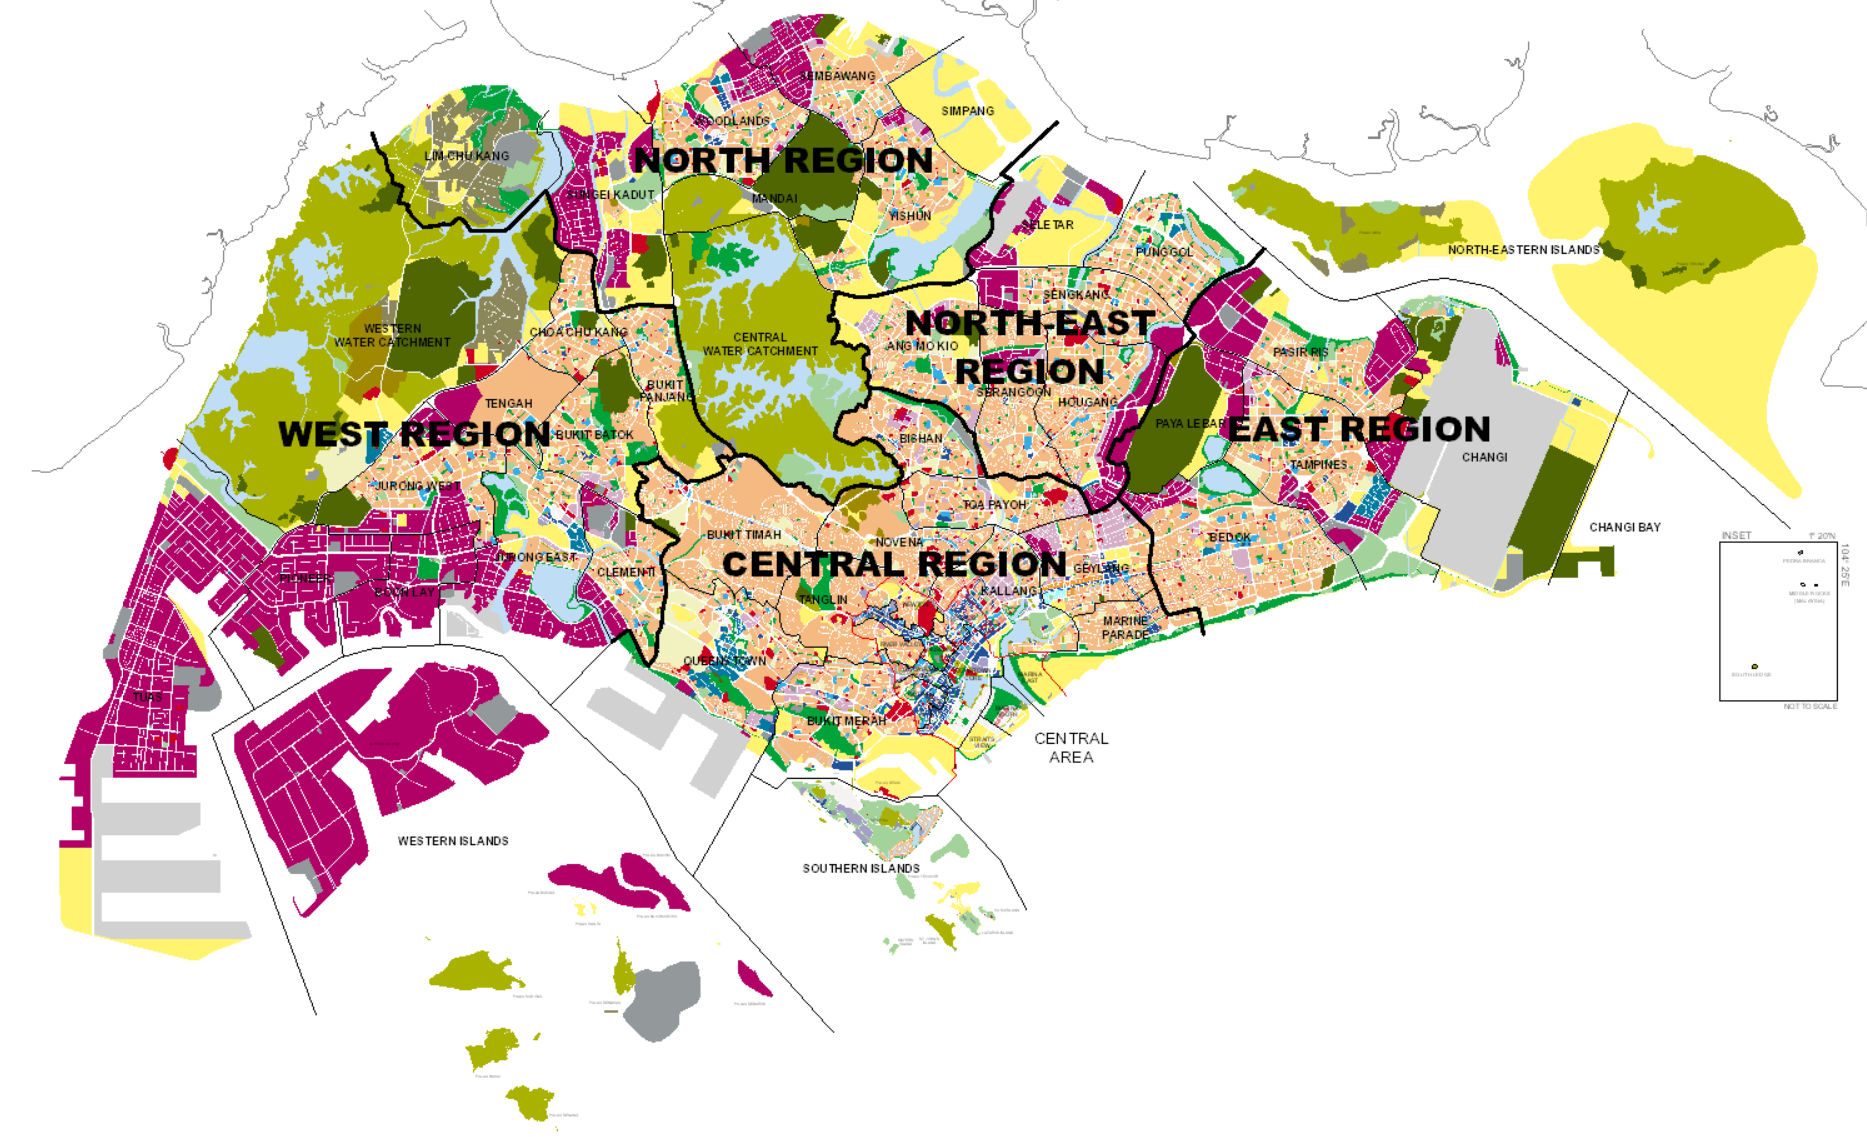

In [1]:
from IPython.display import Image
Image("Data/URA_masterplan_2014.png")

<center>Map of Singapore, Urban Redevelopment Authority, Masterplan 2014, https://www.ura.gov.sg/maps2/?service=MP</center>

## 1. Introduction

### 1.1 Overview

In Singapore, a city-state of just 722 square kilometers, land is a valued and scarce commodity.  Singapore housing is not only attractive due to people's desire to own a home, but is often viewed as a popular asset class by investors.  As reported by Bloomberg, Singapore housing prices are "on a tear" recently with strong buyer and speculative demand.

Singapore offers a wide range of housing options, which can be grouped into 3 broad categories:

###### 1. Public Housing (HDB) 

  - Subsidized and built by the Singapore Government's Housing and Development Boards (hence HDB)
  - 99-year leasehold flats 
  - Relatively cheaper than private housing but only Singapore Citizens and Permanent Residents can buy.
  - While in other countries, public housing is meant for low-income households, in Singapore, HBDs are affordable high quality housing for nearly all socio-economic classes.

###### 2. Private apartments/condominiums

  - Non-landed projects usually with 99-year leasehold, but there are freehold, or 999-year leasehold. 
  - With more facilities e.g. swimming pool, tennis court, fitness centre, and security services than HBDs.
  - No restrictions on foreign ownership and is the primary option for foreigners looking to buy property in Singapore. 

###### 3. Landed properties
  - Can be very expensive depending on the plot size as well as location.
  - Usually tied to the land title. Most are freehold yet some are 99-year leasehold and 999-year leasehold.
  - Only Singapore citizens can buy landed property.

### 1.2 Problem statement
Accurately predict the value of a house in the market.

### 1.3 Expected Output
Develop and test machine learning models to predict the price using not only the sales data with size of house but also many different features, such as:
  - Timing of Sales
  - Location
  - Property Type


We first begin with importing all the relevant packages for the code in this notebook.

In [1]:
import requests
import json
import numpy as np
import pandas as pd
import re
from pandas.io.json import json_normalize
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import matplotlib as mpl
from itertools import combinations
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from shapely.geometry import Point
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA
from IPython.display import display
from sklearn.preprocessing import StandardScaler

#### Note: This project requires Geopandas
#### To install:

conda install -c conda-forge geopandas

In [4]:
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [5]:
pd.__version__

'0.23.4'

## 2. Data Processing

The data for housing transactions are downloaded from two sources: 

1) Private housing transactions, attained from Singapore's Urban Redevelopment Authority (or URA) website.    
2) Public housing transactions, attained from Singapore's Housing Development Board (or HDB) website.


### 2.1 URA Website Token for Request

The process for acquiring the data from the URA website included pre-registering for a token prior to being able to download the relevant data. The token request, and the downloading of the housing data was only to be performed once, and the code is left within the notebook for reference.

Note: The following code is not to be re-run.

In [6]:
# heads1 = {'AccessKey':'c2391955-6093-4ea5-94a2-77fb159ebf63'}

In [7]:
# r1 = requests.get('https://www.ura.gov.sg/uraDataService/insertNewToken.action', headers=heads1)

In [8]:
# r1.json()['Result']

In [9]:
# heads2 = {'AccessKey':'c2391955-6093-4ea5-94a2-77fb159ebf63',
#         'Token':r1.json()['Result']}

### 2.2 Private Housing Data  - Downloading and Formating

The data is downloaded in 4 parts as json files `data1.json`, `data2.json`, `data3.json`, and `data4.json`.
The json files are then read into a pandas dataframe and the columns are re-arranged for preference.

##### Note: The following code is not to be re-run.

In [10]:
# for i in range(4):
    
#     r = requests.get('https://www.ura.gov.sg/uraDataService/invokeUraDS?service=PMI_Resi_Transaction&batch=' + str(i + 1),
#                      headers=heads2)
#     with open('data' + str(i + 1) + '.json', 'w') as outfile:
#         json.dump(r.json()['Result'], outfile)

In [11]:
# # Create dataframe
# df = pd.DataFrame()
# for n in range(4):
#     with open('data' + str(n+1) + '.json', encoding='utf-8') as data_file:
#         loaded = json.loads(data_file.read())
#     loaded = json_normalize(data=loaded, record_path='transaction', meta=['marketSegment', 'project', 'street', 'x', 'y'], errors='ignore')

#     df = df.append(loaded)

In [12]:
# # Rearranging columns and saving the dataframe
# cols = df.columns.tolist()
# cols = (cols[-5:] + cols[:-5])
# df = df[cols]
# df.to_csv('Data/raw_private_housing_data_2015_onwards.csv', index=False)

Once the extracted data is saved in the `Data` folder as a comma separated values file, it is used for all subsequent analysis for loading, transformations, and cleaning.

In [2]:
df = pd.read_csv('Data/raw_private_housing_data_2015_onwards.csv')
df.shape

(73228, 16)

In [3]:
df_private = pd.DataFrame(index=df.index)
df_private['year_of_sale'] = ("20"+ df['contractDate'].astype(str).str[-2:]).astype(int)
df_private['month_of_sale'] = (df['contractDate'].astype(str).str[:-2]).astype(int)
df_private['x_location'] = df['x'].astype(float)
df_private['y_location'] = df['y'].astype(float)
df_private['address'] = np.where(df['project']=='LANDED HOUSING DEVELOPMENT', 
                                     df['street'], np.where(df['project']=='RESIDENTIAL APARTMENTS', df['street'], 
                                                            np.where(df['project']=='SUN ROSIER', df['street'], 
                                                                     np.where(df['project']=='THE BROOKS I & II', 'THE BROOKS I',
                                                                              df['project']))))
df_private['storey_level'] = df['floorRange'].astype(str)
df_private['floor_area_sqm'] = df['area'].astype(float)
df_private['property_type'] = df['propertyType'].astype(str)
df_private['type_of_sale'] = df['typeOfSale'].astype(int)
df_private['lease_commence_date'] = np.where(df['tenure'].str.contains('commencing', case=False, na=False), 
                                             df['tenure'].astype(str).str[-4:], 0).astype(int)
df_private['lease_term'] = df['tenure'].str.extract(r'(\d+) y', expand=False)
df_private['lease_term'] = (df_private['lease_term'].fillna(0)).astype(int)
df_private['remaining_lease'] = np.where(df_private['lease_commence_date'] == 0, 1000, 
                                         (df_private['lease_commence_date']+df_private['lease_term']
                                          -df_private['year_of_sale']))
df_private['sale_price'] = df['price'].astype(float)
df_private = df_private.drop(['lease_term'], axis=1)
df_private.head()

year_of_sale  month_of_sale    x_location    y_location       address  \
0          2018              9  22726.561999  29491.915576  ZEHNDER ROAD   
1          2018              6  22726.561999  29491.915576  ZEHNDER ROAD   
2          2018              9  28384.068816  25005.804519     TURQUOISE   
3          2018              7  28384.068816  25005.804519     TURQUOISE   
4          2017             11  28384.068816  25005.804519     TURQUOISE   

  storey_level  floor_area_sqm  property_type  type_of_sale  \
0            -           308.0  Semi-detached             3   
1            -           314.0  Semi-detached             3   
2        06-10           348.0    Condominium             3   
3        01-05           194.0    Condominium             3   
4        01-05           224.0    Condominium             3   

   lease_commence_date  remaining_lease  sale_price  
0                    0             1000   5000000.0  
1                    0             1000   4750000.0  
2                 2007               88   4400000.0  
3                 2007               88   3100000.0  
4                 2007               89   3700000.0

### 2.3 Public Housing Data  - Downloading and Formating

The dataset for the public housing was downloaded from data.gov.sg (https://data.gov.sg/dataset/resale-flat-prices) in csv format, and saved into the `Data` folder.

Data wrangling and string manipulation techniques were performed to align the public housing data set to the private housing dataset in terms of schema.

In [4]:
df2 = pd.read_csv('Data/raw_public_housing_data_2015_onwards.csv')
df2.shape

(73819, 11)

In [5]:
df_public = pd.DataFrame(index=df2.index)
df_public['year_of_sale'] = (df2['month'].astype(str).str[:4]).astype(int)
df_public['month_of_sale'] = (df2['month'].astype(str).str[-2:]).astype(int)
df_public['x_location'] = 0
df_public['y_location'] = 0
df_public['address'] = df2.block + ' ' + df2.street_name
df_public['storey_level'] = df2['storey_range'].astype(str)
df_public['floor_area_sqm'] = df2['floor_area_sqm'].astype(float)
df_public['property_type'] = str("HDB")
df_public['type_of_sale'] = 3
df_public['lease_commence_date'] = df2['lease_commence_date'].astype(int) 
df_public['remaining_lease'] = df2['remaining_lease'].astype(int)
df_public['sale_price'] = df2['resale_price'].astype(float)
df_public.head()

year_of_sale  month_of_sale  x_location  y_location                address  \
0          2015              1           0           0   174 ANG MO KIO AVE 4   
1          2015              1           0           0  541 ANG MO KIO AVE 10   
2          2015              1           0           0   163 ANG MO KIO AVE 4   
3          2015              1           0           0  446 ANG MO KIO AVE 10   
4          2015              1           0           0  557 ANG MO KIO AVE 10   

  storey_level  floor_area_sqm property_type  type_of_sale  \
0     07 TO 09            60.0           HDB             3   
1     01 TO 03            68.0           HDB             3   
2     01 TO 03            69.0           HDB             3   
3     01 TO 03            68.0           HDB             3   
4     07 TO 09            68.0           HDB             3   

   lease_commence_date  remaining_lease  sale_price  
0                 1986               70    255000.0  
1                 1981               65    275000.0  
2                 1980               64    285000.0  
3                 1979               63    290000.0  
4                 1980               64    290000.0

In [6]:
df_public.shape

(73819, 12)

### 2.4 Combining the Dataset

The two datasets for private housing and public housing transactions were merged into a single dataframe, with a combined 147,047 records.

In [7]:
df_combined = pd.concat([df_private, df_public], ignore_index=True)
df_combined.shape

(147047, 12)

In [8]:
df_combined.head()

year_of_sale  month_of_sale    x_location    y_location       address  \
0          2018              9  22726.561999  29491.915576  ZEHNDER ROAD   
1          2018              6  22726.561999  29491.915576  ZEHNDER ROAD   
2          2018              9  28384.068816  25005.804519     TURQUOISE   
3          2018              7  28384.068816  25005.804519     TURQUOISE   
4          2017             11  28384.068816  25005.804519     TURQUOISE   

  storey_level  floor_area_sqm  property_type  type_of_sale  \
0            -           308.0  Semi-detached             3   
1            -           314.0  Semi-detached             3   
2        06-10           348.0    Condominium             3   
3        01-05           194.0    Condominium             3   
4        01-05           224.0    Condominium             3   

   lease_commence_date  remaining_lease  sale_price  
0                    0             1000   5000000.0  
1                    0             1000   4750000.0  
2                 2007               88   4400000.0  
3                 2007               88   3100000.0  
4                 2007               89   3700000.0

### 2.5 Data Munging of the Combined Dataset

Further data munging on the combined dataset was perfomed in three main areas: correcting the storey levels, attaining X and Y coordinates for public housing records, and adjusting the sale price against a price index.

#### 2.5.1 Storey Levels
The data has the storey levels of the housing reported in a range and in different formats (e.g: `'06-10'`, `'07 TO 09'`), hence the data was transformed to establish the min and max floor bins for each entry, and subsequently an average of the min and max bins was used as the approximate storey level for the transaction. 

In [9]:
df_combined.storey_level.unique()

array(['-', '06-10', '01-05', '31-35', '11-15', '26-30', '21-25', '36-40',
       '16-20', '41-45', '46-50', '51-55', '61-65', '56-60', '66-70',
       'B1-B5', '71-75', '07 TO 09', '01 TO 03', '13 TO 15', '10 TO 12',
       '04 TO 06', '19 TO 21', '16 TO 18', '22 TO 24', '25 TO 27',
       '28 TO 30', '34 TO 36', '46 TO 48', '31 TO 33', '37 TO 39',
       '43 TO 45', '40 TO 42', '49 TO 51'], dtype=object)

In [10]:
# cleaning of storey_level to be numerical data
# put-in 2 variables as the min and max bin limits
# logic: '-' --> 0, B1 --> -1; B5 --> -5
# setting the storey_level as the mean of the two bin limits
storey_min = list(map(lambda x :
                    0 if x == '-' else(
                    -5 if x == 'B1-B5' else 
                    int(x[:2])), df_combined.storey_level))

storey_max = list(map(lambda x :
                    0 if x == '-' else(
                    -1 if x == 'B1-B5' else(
                    int(x[3:]) if re.match(r"\d{2}-\d{2}", x) else
                    int(x[6:]))), df_combined.storey_level))

df_combined['storey_level'] = [int(np.around(sum(x)/2, decimals=0)) for x in zip(storey_min, storey_max)]

In [11]:
df_combined.storey_level.unique()

array([ 0,  8,  3, 33, 13, 28, 23, 38, 18, 43, 48, 53, 63, 58, 68, -3, 73,
        2, 14, 11,  5, 20, 17, 26, 29, 35, 47, 32, 44, 41, 50],
      dtype=int64)

#### 2.5.2 X and Y Location Coordinates

It was observed that location (x, y) values were missing in some of the data. 
Using the `project` and `address` values in the dataset, the missing location (x, y) values were populated by making a call to the OneMap API (https://docs.onemap.sg/).

##### Note: The following code is not to be re-run.

In [12]:
# privatemissing = pd.read_csv('data/privatenans.csv')
# privatemissing['address'] = np.where(privatemissing['project']=='LANDED HOUSING DEVELOPMENT', 
#                                      privatemissing['street'], 
#                                      np.where(privatemissing['project']=='RESIDENTIAL APARTMENTS',
#                                               privatemissing['street'],
#                                               np.where(privatemissing['project']=='SUN ROSIER', 
#                                                        privatemissing['street'], 
#                                                        np.where(privatemissing['project']=='THE BROOKS I & II', 'THE BROOKS I',
#                                                        privatemissing['project']))))
# adds = privatemissing.address.unique()
# adds = pd.DataFrame(adds, columns=['address'])
# adds['x'] = -999
# adds['y'] = -999
# adds.head()

In [13]:
# for i in adds.index:
#     search = adds.loc[i, 'address']
#     r = requests.get('https://developers.onemap.sg/commonapi/search',
#                  params={'searchVal':search,
#                          'returnGeom':'Y',
#                          'getAddrDetails':'N',
#                          'pageNum':1}
#                     )
#     print(search)
#     print(r.json()['results'][0])
#     adds.loc[i, 'x'] = r.json()['results'][0]['X']
#     adds.loc[i, 'y'] = r.json()['results'][0]['Y']
#     #adds.loc[i, 'latitude'] = r.json()['results'][0]['LATITUDE']
#     #adds.loc[i, 'longitude'] = r.json()['results'][0]['LONGITUDE']
#     print(f'{i} complete')

The X and Y coordinates for addresses extracted from the private dataset and the public dataset are saved in the `Data` folder, and is used to replace the address column in the combined dataframe.

In [14]:
dfxyprivate = pd.read_csv('Data/coord_mapping_address_private.csv')
dfxyprivate.head()

Unnamed: 0              address             x             y
0           0                ARTRA  26196.012496  30258.525669
1           1      LIIV RESIDENCES  21692.470254  30106.788392
2           2  STIRLING RESIDENCES  24859.022384  30450.752730
3           3   THE CLEMENT CANOPY  20780.627449  32132.353038
4           4             TWIN VEW  19002.127369  33567.163614

In [15]:
dfxypublic = pd.read_csv('Data/coord_mapping_address_public.csv')
dfxypublic.head()

Unnamed: 0                address             x             y
0           0   174 ANG MO KIO AVE 4  28478.579445  39676.807613
1           1  541 ANG MO KIO AVE 10  30482.026549  39546.884714
2           2   163 ANG MO KIO AVE 4  28540.623787  39505.534986
3           3  446 ANG MO KIO AVE 10  30452.627801  38865.583668
4           4  557 ANG MO KIO AVE 10  30717.373319  39292.930731

In [16]:
dfxycombined = pd.concat([dfxyprivate, dfxypublic], ignore_index=True)
dfxycombined = dfxycombined.drop(dfxycombined.columns[0], axis=1)
df_combined2 = df_combined.merge(dfxycombined, on='address', how='left')

In [17]:
df_combined2['x_location'] = df_combined2.x_location.fillna(0)
df_combined2['y_location'] = df_combined2.y_location.fillna(0)
df_combined2['x_location'] = np.where(df_combined2['x_location'] == 0, df_combined2['x'], df_combined2['x_location'])
df_combined2['y_location'] = np.where(df_combined2['y_location'] == 0, df_combined2['y'], df_combined2['y_location'])
df_combined2.head()

year_of_sale  month_of_sale    x_location    y_location       address  \
0          2018              9  22726.561999  29491.915576  ZEHNDER ROAD   
1          2018              6  22726.561999  29491.915576  ZEHNDER ROAD   
2          2018              9  28384.068816  25005.804519     TURQUOISE   
3          2018              7  28384.068816  25005.804519     TURQUOISE   
4          2017             11  28384.068816  25005.804519     TURQUOISE   

   storey_level  floor_area_sqm  property_type  type_of_sale  \
0             0           308.0  Semi-detached             3   
1             0           314.0  Semi-detached             3   
2             8           348.0    Condominium             3   
3             3           194.0    Condominium             3   
4             3           224.0    Condominium             3   

   lease_commence_date  remaining_lease  sale_price   x   y  
0                    0             1000   5000000.0 NaN NaN  
1                    0             1000   4750000.0 NaN NaN  
2                 2007               88   4400000.0 NaN NaN  
3                 2007               88   3100000.0 NaN NaN  
4                 2007               89   3700000.0 NaN NaN

In [18]:
df_combined = df_combined2.drop(['address', 'x', 'y'], axis=1)

#### 2.5.3 Adjusting the Sale Price against the Price Index

In order to remove the effects of trends in the data, the sale prices were normalized by dividing the sale price by the price index for the quarter and then multipled by the current quarter's price index to adjust the prices to current period.  The price index by property type was obtained from the following sources: 

Private property price index: https://data.gov.sg/dataset/private-residential-property-price-index-by-type-of-property    
Public property price index: https://data.gov.sg/dataset/hdb-resale-price-index


Assumption: Since Q4 2018 price index isn't available yet, Q3 2018 index was used to normalize for Oct and Nov 2018 property sales.

In [19]:
df = df_combined.copy()
df.shape

(147047, 11)

In [20]:
df['quarter'] = pd.cut(df['month_of_sale'].astype(int), [0, 3, 6, 9, 12], labels=['Q1', 'Q2', 'Q3', 'Q4'])
df['quarter'] = df['year_of_sale'].astype(str) + "-" +  df['quarter'].astype(str)
df.head()

year_of_sale  month_of_sale    x_location    y_location  storey_level  \
0          2018              9  22726.561999  29491.915576             0   
1          2018              6  22726.561999  29491.915576             0   
2          2018              9  28384.068816  25005.804519             8   
3          2018              7  28384.068816  25005.804519             3   
4          2017             11  28384.068816  25005.804519             3   

   floor_area_sqm  property_type  type_of_sale  lease_commence_date  \
0           308.0  Semi-detached             3                    0   
1           314.0  Semi-detached             3                    0   
2           348.0    Condominium             3                 2007   
3           194.0    Condominium             3                 2007   
4           224.0    Condominium             3                 2007   

   remaining_lease  sale_price  quarter  
0             1000   5000000.0  2018-Q3  
1             1000   4750000.0  2018-Q2  
2               88   4400000.0  2018-Q3  
3               88   3100000.0  2018-Q3  
4               89   3700000.0  2017-Q4

In [21]:
df_hdb_index = pd.read_csv("Data/housing-and-development-board-resale-price-index-1q2009-100-quarterly.csv")
df_hdb_index = df_hdb_index.rename(index=str, columns={"index": "price_index"})
df_hdb_index.head()

quarter  price_index
0  1990-Q1         24.3
1  1990-Q2         24.4
2  1990-Q3         25.0
3  1990-Q4         24.7
4  1991-Q1         24.9

In [22]:
df_priv_index = pd.read_csv("Data/private-residential-property-price-index-by-type-of-property-base-quarter-2009-q1-100.csv")
df_priv_index = df_priv_index.rename(index=str, columns={"value": "price_index"})
df_landed_index = df_priv_index[df_priv_index['level_2'] == 'Landed']
df_landed_index = df_landed_index.drop(df_landed_index.columns[1:3], axis=1)
df_non_landed_index = df_priv_index[df_priv_index['level_2'] == 'Non-landed']
df_non_landed_index = df_non_landed_index.drop(df_non_landed_index.columns[1:3], axis=1)
df_non_landed_index.head()

quarter  price_index
1  1975-Q1         10.5
3  1975-Q2         11.2
5  1975-Q3         11.5
7  1975-Q4         11.5
9  1976-Q1         11.5

In [23]:
df_hdb = df[df['property_type'] == 'HDB']
df_priv_nonland = df[(df['property_type'] == 'Apartment') | (df['property_type'] == 'Condominium') 
   | (df['property_type'] == 'Executive Condominium')]
df_priv_landed = df[(df['property_type'] != 'Apartment') & (df['property_type'] != 'Condominium') 
   & (df['property_type'] != 'Executive Condominium') & (df['property_type'] != 'HDB')]
df_hdb2 = df_hdb.merge(df_hdb_index, on='quarter', how = 'left')
df_priv_nonland2 = df_priv_nonland.merge(df_non_landed_index, on='quarter', how = 'left')
df_priv_landed2 = df_priv_landed.merge(df_landed_index, on='quarter', how = 'left')

In [24]:
# Setting the latest quarter to be 2018-Q3 in accordance to our assumption for normalizing price to present day values.
latest_quarter = '2018-Q3' 

# Calculating the index for 'present day' prices
index_hdb = df_hdb_index[df_hdb_index.quarter == latest_quarter].price_index.values[0]
index_priv_non_landed = df_non_landed_index[df_non_landed_index.quarter == latest_quarter].price_index.values[0]
index_priv_landed = df_landed_index[df_landed_index.quarter == latest_quarter].price_index.values[0]

print('Price indices for the latest quarter of {} is as follows:'.format(latest_quarter))
print('HDB: {} , Private Non-Landed: {} , Private Landed: {}'.format(
    index_hdb, index_priv_non_landed, index_priv_landed))

print('\nAdjusting the sale price in the dataset:')
# Adjusted sale price = sale price divided by price index for the month and then multipled by the current period's price index
df_hdb2['adj_saleprice'] = (df_hdb2['sale_price']/df_hdb2['price_index'])*index_hdb
df_priv_nonland2['adj_saleprice'] = (df_priv_nonland2['sale_price']/df_priv_nonland2['price_index'])*index_priv_non_landed
df_priv_landed2['adj_saleprice'] = (df_priv_landed2['sale_price']/df_priv_landed2['price_index'])*index_priv_landed

combined_df = pd.concat([df_hdb2, df_priv_nonland2, df_priv_landed2], ignore_index=True)
combined_df.head()

Price indices for the latest quarter of 2018-Q3 is as follows:
HDB: 131.6 , Private Non-Landed: 146.1 , Private Landed: 165.9

Adjusting the sale price in the dataset:


year_of_sale  month_of_sale    x_location    y_location  storey_level  \
0          2015              1  28478.579445  39676.807613             8   
1          2015              1  30482.026549  39546.884714             2   
2          2015              1  28540.623787  39505.534986             2   
3          2015              1  30452.627801  38865.583668             2   
4          2015              1  30717.373319  39292.930731             8   

   floor_area_sqm property_type  type_of_sale  lease_commence_date  \
0            60.0           HDB             3                 1986   
1            68.0           HDB             3                 1981   
2            69.0           HDB             3                 1980   
3            68.0           HDB             3                 1979   
4            68.0           HDB             3                 1980   

   remaining_lease  sale_price  quarter  price_index  adj_saleprice  
0               70    255000.0  2015-Q1        135.6  247477.876106  
1               65    275000.0  2015-Q1        135.6  266887.905605  
2               64    285000.0  2015-Q1        135.6  276592.920354  
3               63    290000.0  2015-Q1        135.6  281445.427729  
4               64    290000.0  2015-Q1        135.6  281445.427729

In [25]:
# Dropping the quarter and sale price columns since now we have adjusted sale price
df_combined = combined_df.drop(['quarter', 'sale_price'], axis=1)
df_combined.head()

year_of_sale  month_of_sale    x_location    y_location  storey_level  \
0          2015              1  28478.579445  39676.807613             8   
1          2015              1  30482.026549  39546.884714             2   
2          2015              1  28540.623787  39505.534986             2   
3          2015              1  30452.627801  38865.583668             2   
4          2015              1  30717.373319  39292.930731             8   

   floor_area_sqm property_type  type_of_sale  lease_commence_date  \
0            60.0           HDB             3                 1986   
1            68.0           HDB             3                 1981   
2            69.0           HDB             3                 1980   
3            68.0           HDB             3                 1979   
4            68.0           HDB             3                 1980   

   remaining_lease  price_index  adj_saleprice  
0               70        135.6  247477.876106  
1               65        135.6  266887.905605  
2               64        135.6  276592.920354  
3               63        135.6  281445.427729  
4               64        135.6  281445.427729

#### 2.5.4 Changing Floor Area from Square Meter to Square Feet

Although Singapore predominantly adopts the S.I. metric system for units of measure, the norm of the property market is to represent floor area in terms of square footage rather than square meters.  Hence the `floor_area_sqm` column was converted to `floor_area_sqf`.

In [26]:
# Inserting a new column `floor_area_sqf` and converting square meter to square feet 
# 1 m = 3.28084 ft
df_combined.insert(loc=df_combined.columns.get_loc('floor_area_sqm')+1, 
                   column='floor_area_sqf', 
                   value=df_combined['floor_area_sqm'] * (3.28084**2) )

# Dropping column `floor_area_sqm`
df_combined.drop(['floor_area_sqm'],inplace=True, axis=1)
df_combined.head()

year_of_sale  month_of_sale    x_location    y_location  storey_level  \
0          2015              1  28478.579445  39676.807613             8   
1          2015              1  30482.026549  39546.884714             2   
2          2015              1  28540.623787  39505.534986             2   
3          2015              1  30452.627801  38865.583668             2   
4          2015              1  30717.373319  39292.930731             8   

   floor_area_sqf property_type  type_of_sale  lease_commence_date  \
0      645.834666           HDB             3                 1986   
1      731.945955           HDB             3                 1981   
2      742.709866           HDB             3                 1980   
3      731.945955           HDB             3                 1979   
4      731.945955           HDB             3                 1980   

   remaining_lease  price_index  adj_saleprice  
0               70        135.6  247477.876106  
1               65        135.6  266887.905605  
2               64        135.6  276592.920354  
3               63        135.6  281445.427729  
4               64        135.6  281445.427729

#### 2.5.5 Adding Price per Square Foot as a Potential Alternate Output Variable

Another metric used widely in the Singapore property market is the Price per Square Foot (PSF). The property market is highly competitive across homes of varying sizes and it is another market norm for buyers and sellers to be highly sensitive to the price per square foot while participating in the market.


In [27]:
# Inserting a new column `adj_salePSF` 
df_combined.insert(loc=df_combined.columns.get_loc('adj_saleprice')+1, 
                   column='adj_salePSF', 
                   value=df_combined['adj_saleprice'] / df_combined['floor_area_sqf'])

In [28]:
df_combined.head()

year_of_sale  month_of_sale    x_location    y_location  storey_level  \
0          2015              1  28478.579445  39676.807613             8   
1          2015              1  30482.026549  39546.884714             2   
2          2015              1  28540.623787  39505.534986             2   
3          2015              1  30452.627801  38865.583668             2   
4          2015              1  30717.373319  39292.930731             8   

   floor_area_sqf property_type  type_of_sale  lease_commence_date  \
0      645.834666           HDB             3                 1986   
1      731.945955           HDB             3                 1981   
2      742.709866           HDB             3                 1980   
3      731.945955           HDB             3                 1979   
4      731.945955           HDB             3                 1980   

   remaining_lease  price_index  adj_saleprice  adj_salePSF  
0               70        135.6  247477.876106   383.190759  
1               65        135.6  266887.905605   364.627885  
2               64        135.6  276592.920354   372.410457  
3               63        135.6  281445.427729   384.516679  
4               64        135.6  281445.427729   384.516679

## 3. Exploratory Data Analysis

An exploratory data analysis was conducted on the combined and cleaned dataset.  There are a total fo 12 columns, 10 of which are input variables and the output variable would either be the index adjusted sale price `adj_saleprice` or the index adjusted price per square foot `adj_salePSF`.

The summary descriptive statistics are provided below, and checks were performed to ensure no null values in the dataset.

In [30]:
df_features = pd.DataFrame(df_combined.columns.tolist())
df_features.columns = ["Features"]
df_features

Features
0          year_of_sale
1         month_of_sale
2            x_location
3            y_location
4          storey_level
5        floor_area_sqf
6         property_type
7          type_of_sale
8   lease_commence_date
9       remaining_lease
10          price_index
11        adj_saleprice
12          adj_salePSF

In [31]:
df_combined.describe()

year_of_sale  month_of_sale     x_location     y_location  \
count  147047.000000  147047.000000  147047.000000  147047.000000   
mean     2016.721082       6.414412   29182.144042   37392.515066   
std         0.994915       3.159686    7471.528760    4832.604039   
min      2015.000000       1.000000   11519.146494   24666.723544   
25%      2016.000000       4.000000   23838.848861   33572.706802   
50%      2017.000000       6.000000   29429.442190   37034.371803   
75%      2018.000000       9.000000   34982.646781   40468.651513   
max      2018.000000      12.000000   45192.299295   49246.360640   

        storey_level  floor_area_sqf   type_of_sale  lease_commence_date  \
count  147047.000000   147047.000000  147047.000000        147047.000000   
mean        8.790298     1250.949940       2.513849          1708.605854   
std         7.114008     5272.334417       0.853078           702.238358   
min        -3.000000      258.333867       1.000000             0.000000   
25%         3.000000      796.529422       3.000000          1980.000000   
50%         8.000000     1054.863288       3.000000          1997.000000   
75%        13.000000     1291.669333       3.000000          2012.000000   
max        73.000000   947073.482537       3.000000          2018.000000   

       remaining_lease    price_index  adj_saleprice    adj_salePSF  
count    147047.000000  147047.000000   1.470470e+05  147047.000000  
mean        242.807307     136.639816   1.215589e+06     898.808733  
std        3703.555360       5.978885   8.378927e+06     606.856775  
min           3.000000     131.600000   4.091245e+04      33.726217  
25%          72.000000     133.700000   4.009918e+05     390.764523  
50%          87.000000     134.700000   7.117741e+05     715.185531  
75%          97.000000     136.500000   1.266637e+06    1329.029515  
max      999942.000000     165.900000   1.053658e+09    5967.608216

In [32]:
df_combined.isnull().sum()

year_of_sale           0
month_of_sale          0
x_location             0
y_location             0
storey_level           0
floor_area_sqf         0
property_type          0
type_of_sale           0
lease_commence_date    0
remaining_lease        0
price_index            0
adj_saleprice          0
adj_salePSF            0
dtype: int64

### 3.1 Scatterplot Matrix

A scatterplot matrix was done and from the data it can be discerned that the sale price of the property seems to have a linear relationship with the floor area, which matches our expectations from knowledge of the property market.  X and Y location also clearly shows certain locations with higher price per square foot than others.

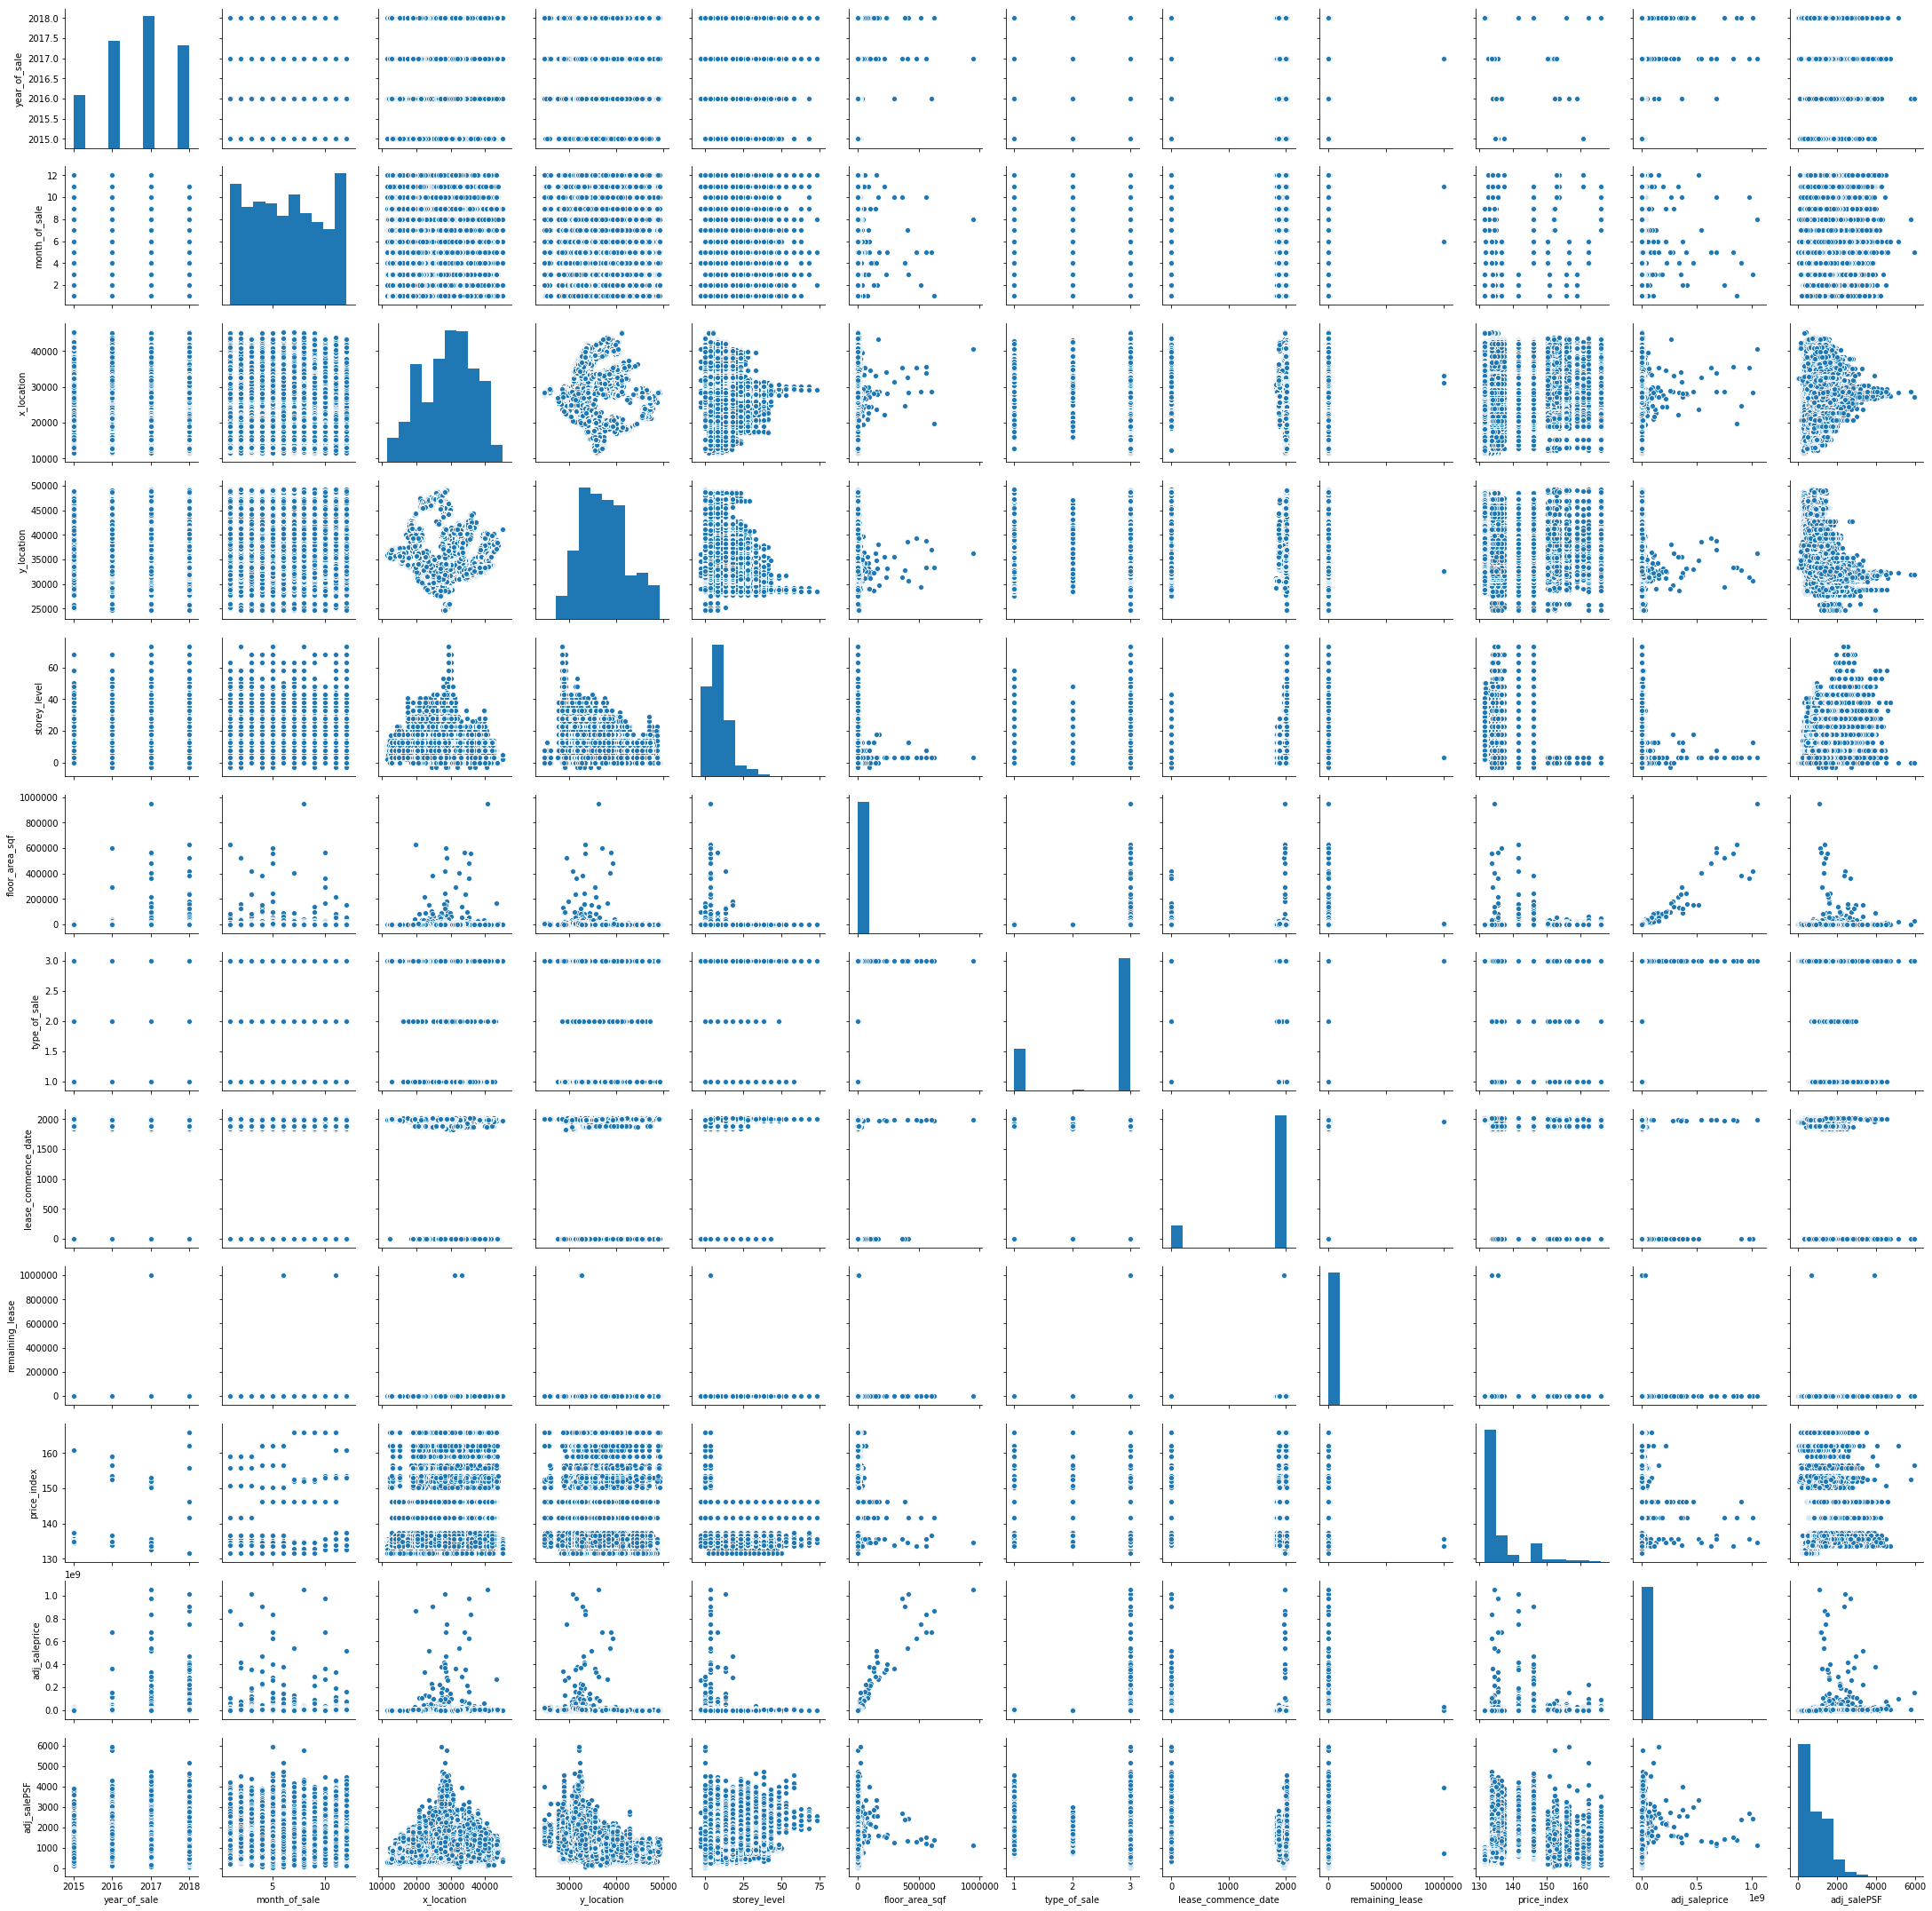

In [33]:
# Plotting a scatterplot matrix with Seaborn
sns.pairplot(df_combined)


### 3.2 Univariate Analysis: Year and Month of Sale

The highest number of recorded transactions occured in 2017, and the most active months for property transactions are between March to July.

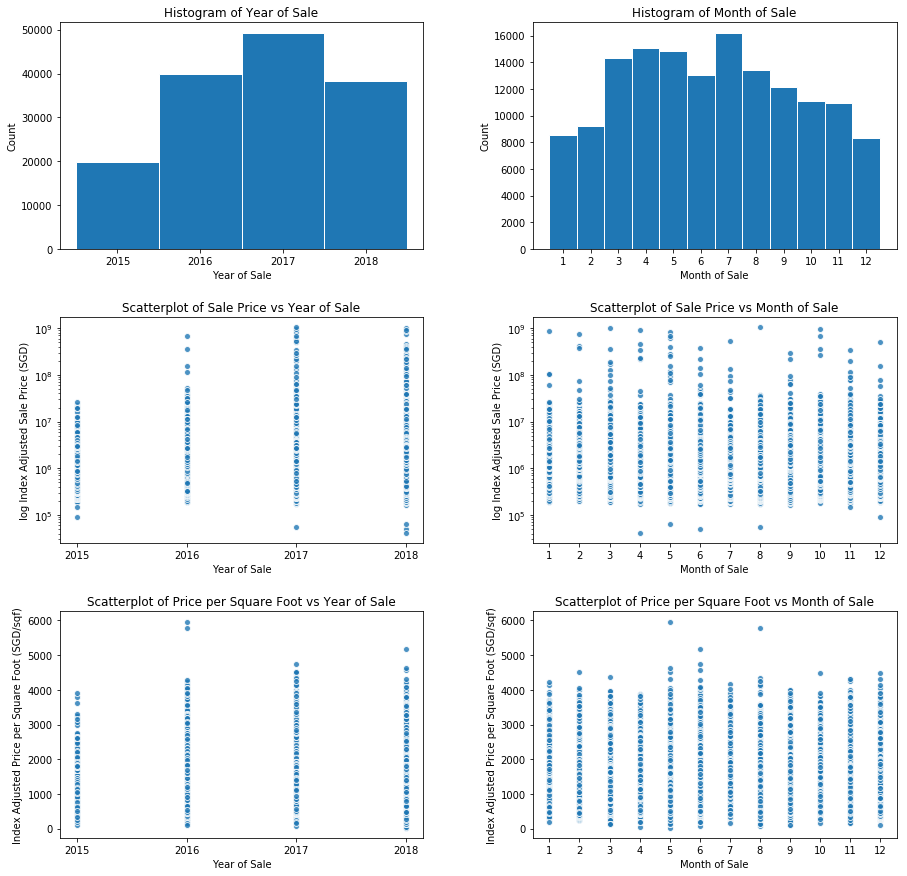

In [44]:
# Plotting histograms for year and month of sale
fig, ax = plt.subplots(3,2, figsize=(15,15))
fig.subplots_adjust(wspace=.3, hspace=.3)

ax[0,0].hist(x='year_of_sale', data=df_combined, bins=4, range=[2014.5,2018.5], edgecolor="w")
ax[0,0].set_title("Histogram of Year of Sale")
ax[0,0].set_xlabel("Year of Sale")
ax[0,0].set_xticks([2015, 2016, 2017, 2018])
ax[0,0].set_ylabel("Count")

ax[0,1].hist(x='month_of_sale', data=df_combined, bins=12, range=[0.5,12.5], edgecolor="w")
ax[0,1].set_title("Histogram of Month of Sale")
ax[0,1].set_xlabel("Month of Sale")
ax[0,1].set_xticks(list(range(1,13)))
ax[0,1].set_ylabel("Count")

# Plotting scatter plots for sale price vs year and month of sale
ax[1,0].scatter(x=df_combined['year_of_sale'], y=df_combined['adj_saleprice'], 
                edgecolor="w", alpha=0.8)
ax[1,0].set_title("Scatterplot of Sale Price vs Year of Sale")
ax[1,0].set_xlabel("Year of Sale")
ax[1,0].set_xticks([2015, 2016, 2017, 2018])
ax[1,0].set_ylabel("log Index Adjusted Sale Price (SGD)")
ax[1,0].set_yscale("log")

ax[1,1].scatter(x=df_combined['month_of_sale'], y=df_combined['adj_saleprice'], 
                edgecolor="w", alpha=0.8)
ax[1,1].set_title("Scatterplot of Sale Price vs Month of Sale")
ax[1,1].set_xlabel("Month of Sale")
ax[1,1].set_xticks(list(range(1,13)))
ax[1,1].set_ylabel("log Index Adjusted Sale Price (SGD)")
ax[1,1].set_yscale("log")

# Plotting scatter plots for PSF vs year and month of sale
ax[2,0].scatter(x=df_combined['year_of_sale'], y=df_combined['adj_salePSF'], 
                edgecolor="w", alpha=0.8)
ax[2,0].set_title("Scatterplot of Price per Square Foot vs Year of Sale")
ax[2,0].set_xlabel("Year of Sale")
ax[2,0].set_xticks([2015, 2016, 2017, 2018])
ax[2,0].set_ylabel("Index Adjusted Price per Square Foot (SGD/sqf)")

ax[2,1].scatter(x=df_combined['month_of_sale'], y=df_combined['adj_salePSF'], 
                edgecolor="w", alpha=0.8)
ax[2,1].set_title("Scatterplot of Price per Square Foot vs Month of Sale")
ax[2,1].set_xlabel("Month of Sale")
ax[2,1].set_xticks(list(range(1,13)))
ax[2,1].set_ylabel("Index Adjusted Price per Square Foot (SGD/sqf)")

plt.show()

### 3.3 Univariate Analysis: X and Y Location

Based on the 2D histogram we see most transactions at the south central, small town clusters in the north, northeast and northwest, as well as along the southeast coastline of Singapore.

From the Price per Square Foot plots against X and Y coordinates, we can see that the highest PSF is between an X coordinate of 25,000 - 30,000 and a Y coordinate of 30,000 - 35,000.

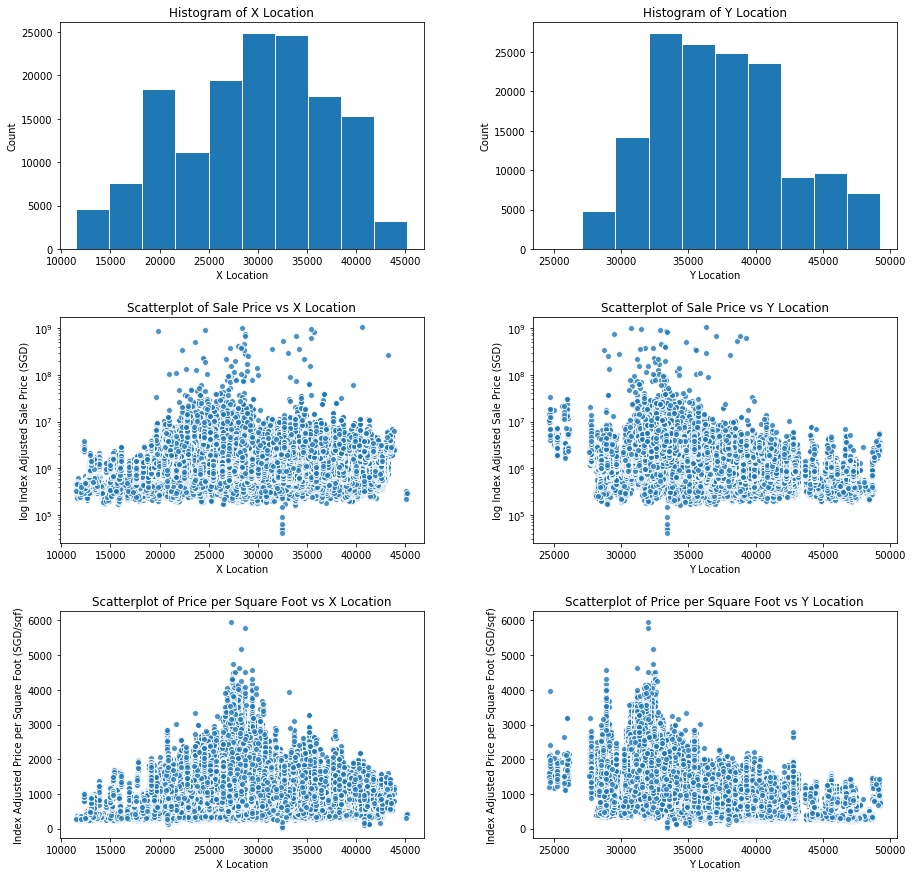

In [45]:
# Plotting histograms for X and Y location
fig, ax = plt.subplots(3,2, figsize=(15,15))
fig.subplots_adjust(wspace=.3, hspace=.3)

ax[0,0].hist(x='x_location', data=df_combined, edgecolor="w")
ax[0,0].set_title("Histogram of X Location")
ax[0,0].set_xlabel("X Location")
ax[0,0].set_ylabel("Count")

ax[0,1].hist(x='y_location', data=df_combined, edgecolor="w")
ax[0,1].set_title("Histogram of Y Location")
ax[0,1].set_xlabel("Y Location")
ax[0,1].set_ylabel("Count")

# Plotting scatter plots for sale price vs X and Y location
ax[1,0].scatter(x=df_combined['x_location'], y=df_combined['adj_saleprice'], edgecolor="w", alpha=0.8)
ax[1,0].set_title("Scatterplot of Sale Price vs X Location")
ax[1,0].set_xlabel("X Location")
ax[1,0].set_ylabel("log Index Adjusted Sale Price (SGD)")
ax[1,0].set_yscale("log")

ax[1,1].scatter(x=df_combined['y_location'], y=df_combined['adj_saleprice'], edgecolor="w", alpha=0.8)
ax[1,1].set_title("Scatterplot of Sale Price vs Y Location")
ax[1,1].set_xlabel("Y Location")
ax[1,1].set_ylabel("log Index Adjusted Sale Price (SGD)")
ax[1,1].set_yscale("log")

# Plotting scatter plots for PSF vs X and Y location
ax[2,0].scatter(x=df_combined['x_location'], y=df_combined['adj_salePSF'], edgecolor="w", alpha=0.8)
ax[2,0].set_title("Scatterplot of Price per Square Foot vs X Location")
ax[2,0].set_xlabel("X Location")
ax[2,0].set_ylabel("Index Adjusted Price per Square Foot (SGD/sqf)")

ax[2,1].scatter(x=df_combined['y_location'], y=df_combined['adj_salePSF'], edgecolor="w", alpha=0.8)
ax[2,1].set_title("Scatterplot of Price per Square Foot vs Y Location")
ax[2,1].set_xlabel("Y Location")
ax[2,1].set_ylabel("Index Adjusted Price per Square Foot (SGD/sqf)")

plt.show()

In plotting this out in a 2D space, we do see that the highest PSF between an X coordinate of 25,000 - 30,000 and a Y coordinate of 30,000 - 35,000 directly lies within the south-central part of Singapore which is the commercial and financial center of the island.

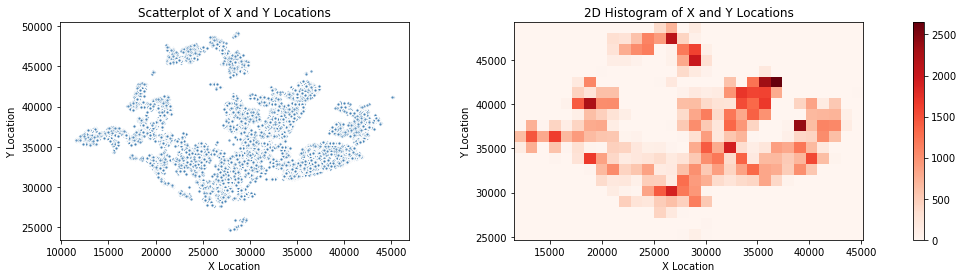

In [46]:
# Plotting histograms for X and Y location
fig, ax = plt.subplots(1,2, figsize=(18,4))
fig.subplots_adjust(wspace=.3)

# Plotting a X and Y Location scatter plot
ax[0].scatter(x='x_location',y='y_location', data=df_combined, c='steelblue', edgecolor="w", s=10, alpha=.8)
ax[0].set_title("Scatterplot of X and Y Locations")
ax[0].set_xlabel("X Location")
ax[0].set_ylabel("Y Location")

# Plotting a 2D histogram
counts, xedges, yedges, im = ax[1].hist2d(x='x_location',y='y_location', data=df_combined, bins=[30,20], cmap='Reds')
ax[1].set_title("2D Histogram of X and Y Locations")
ax[1].set_xlabel("X Location")
ax[1].set_ylabel("Y Location")
fig.colorbar(im, ax=ax)

plt.show()

### 3.3b Geospatial Representation of Home Sales in Singapore

C:\Users\lim_r\Anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


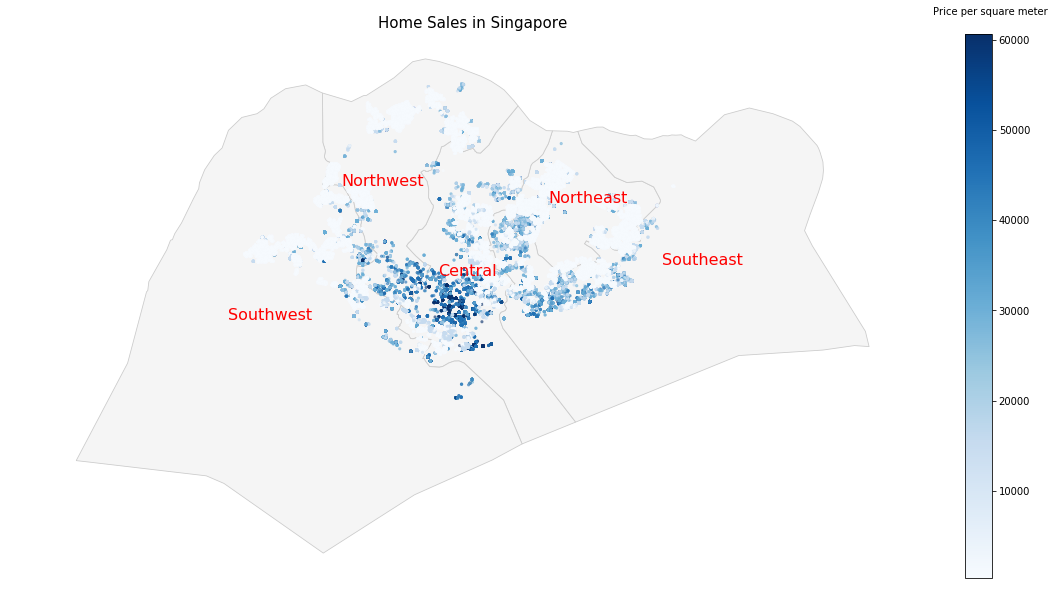

In [67]:
df = pd.read_csv('data/CombinedData_withxy_longlat.csv')
df = df[df['x'] > 0]
df['psm'] = df['sale_price']/df['floor_area_sqm']
df['Coordinates'] = list(zip(df.longitude, df.latitude))
df['Coordinates'] = df['Coordinates'].apply(Point)
geo_df = gpd.GeoDataFrame(df, geometry='Coordinates')
sg_df = gpd.read_file('data\singapore_admin.geojson')
sg_df = sg_df.loc[1:5]
sg_df['coords'] = sg_df['geometry'].apply(lambda x: x.representative_point().coords[:])
sg_df['coords'] = [coords[0] for coords in sg_df['coords']]
fig, ax = plt.subplots(1, figsize=(20,10))
base = sg_df.plot(ax=ax, edgecolor='0.8', alpha=1, linewidth=0.8, color = 'whitesmoke')
for idx, row in sg_df.iterrows():
    plt.annotate(s=row['name'], xy=row['coords'], horizontalalignment='center', color = "red", fontsize = 16)
geo_df.plot(column = geo_df['psm'], ax=base, marker="o",markersize=5, alpha=0.5,  cmap='Blues', scheme='fisher_jenks')
ax.axis('off')
ax.set_title('Home Sales in Singapore', fontdict={'fontsize': '15', 'fontweight' : '2'})
vmin = df['psm'].min()
vmax = df['psm'].max()

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
cbar.set_label('Price per square meter', labelpad=-40, y=1.05, rotation=0)

### 3.4 Univariate Analysis: Storey Level

The histogram of the storey level shows that most housing transactions are concentrated between 0-15 storey levels.  The highest PSF is seen for housing at storey `0` which indicates a landed property such as a Detached or Semi-detached home.

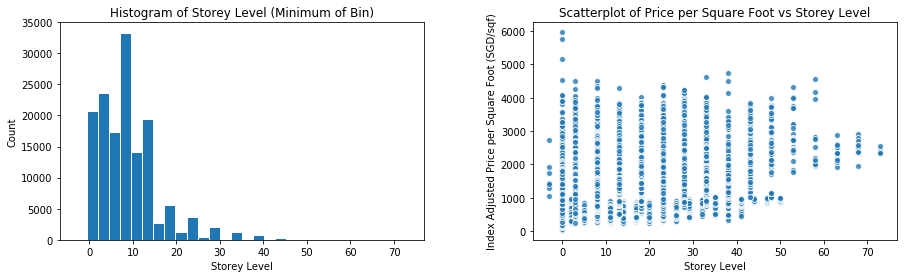

In [47]:
# Plotting histograms for storey level
fig, ax = plt.subplots(1,2, figsize=(15,4))
fig.subplots_adjust(wspace=.3)

ax[0].hist(x='storey_level', data=df_combined, bins=30, edgecolor="w")
ax[0].set_title("Histogram of Storey Level (Minimum of Bin)")
ax[0].set_xlabel("Storey Level")
ax[0].set_ylabel("Count")

# Plotting scatter plot for PSF vs storey level
ax[1].scatter(x=df_combined['storey_level'], y=df_combined['adj_salePSF'], edgecolor="w", alpha=0.8)
ax[1].set_title("Scatterplot of Price per Square Foot vs Storey Level")
ax[1].set_xlabel("Storey Level")
ax[1].set_ylabel("Index Adjusted Price per Square Foot (SGD/sqf)")

plt.show()

### 3.5 Univariate Analysis: Floor Area

The floor area for properties has very extreme outliers.  With a mean of 1250 sqf and a maximum of 947073 sqf the histogram of the full range of floor areas is not meaningful. Instead plotting a bounded range of between 0 to 2500 sqf provides us with more insight on the distribution, which looks normal when the outliers are excluded.

In [48]:
# Number of transactions with > 2500 sqf
print("Number of property transactions which have floor areas > 2500 sqf: {} or {:.2f}%".format(
    df_combined[df_combined.floor_area_sqf > 2500].floor_area_sqf.count(),
    df_combined[df_combined.floor_area_sqf > 2500].floor_area_sqf.count() / df_combined.shape[0]
))

Number of property transactions which have floor areas > 2500 sqf: 5532 or 0.04%


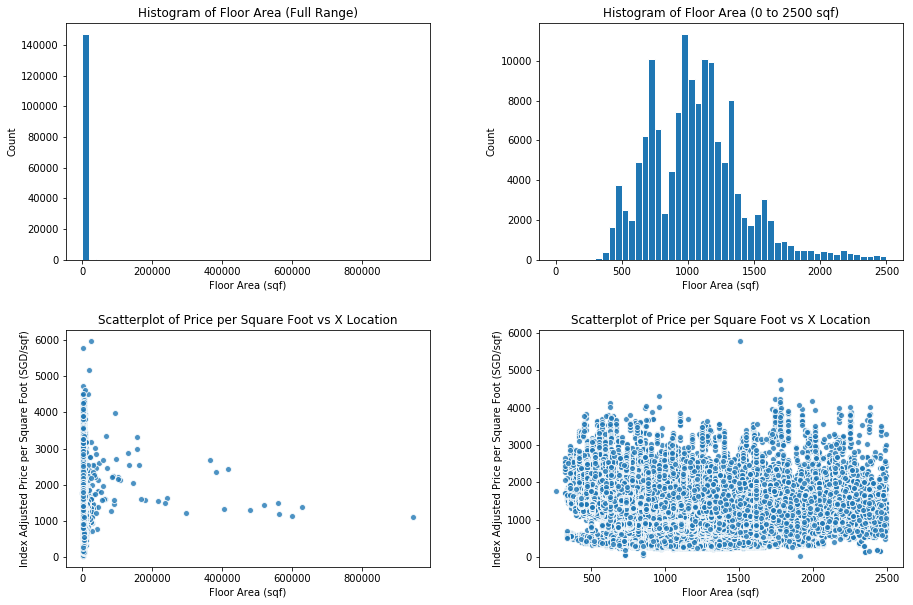

In [49]:
# Plotting histogram for floor area
fig, ax = plt.subplots(2,2, figsize=(15,10))
fig.subplots_adjust(wspace=.3, hspace=.3)

ax[0,0].hist(x='floor_area_sqf', data=df_combined, bins=50, edgecolor="w")
ax[0,0].set_title("Histogram of Floor Area (Full Range)")
ax[0,0].set_xlabel("Floor Area (sqf)")
ax[0,0].set_ylabel("Count")

ax[0,1].hist(x='floor_area_sqf', data=df_combined, bins=50, range=[0,2500], edgecolor="w")
ax[0,1].set_title("Histogram of Floor Area (0 to 2500 sqf)")
ax[0,1].set_xlabel("Floor Area (sqf)")
ax[0,1].set_ylabel("Count")

# Plotting scatter plots for PSF vs floor area
ax[1,0].scatter(x=df_combined['floor_area_sqf'], y=df_combined['adj_salePSF'], edgecolor="w", alpha=0.8)
ax[1,0].set_title("Scatterplot of Price per Square Foot vs X Location")
ax[1,0].set_xlabel("Floor Area (sqf)")
ax[1,0].set_ylabel("Index Adjusted Price per Square Foot (SGD/sqf)")

ax[1,1].scatter(x=df_combined[df_combined['floor_area_sqf'] <= 2500]['floor_area_sqf'], 
                y=df_combined[df_combined['floor_area_sqf'] <= 2500]['adj_salePSF'], edgecolor="w", alpha=0.8)
ax[1,1].set_title("Scatterplot of Price per Square Foot vs X Location")
ax[1,1].set_xlabel("Floor Area (sqf)")
ax[1,1].set_ylabel("Index Adjusted Price per Square Foot (SGD/sqf)")

plt.show()

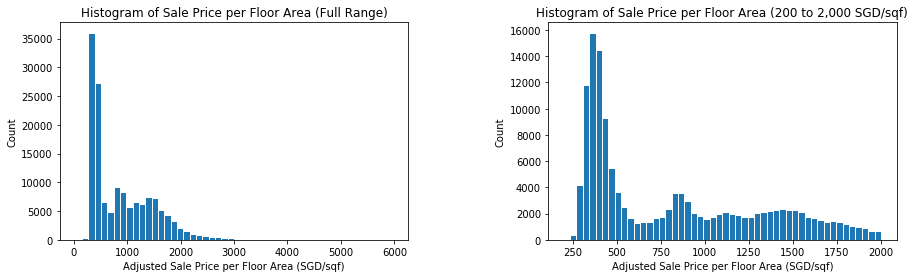

In [50]:
# Plotting histogram for sale price per floor area
fig, ax = plt.subplots(1,2, figsize=(15,4))
fig.subplots_adjust(wspace=.4)

ax[0].hist(x=df_combined.adj_salePSF, bins=50, edgecolor="w")
ax[0].set_title("Histogram of Sale Price per Floor Area (Full Range)")
ax[0].set_xlabel("Adjusted Sale Price per Floor Area (SGD/sqf)")
ax[0].set_ylabel("Count")

ax[1].hist(x=df_combined.adj_salePSF, bins=50, range=[200,2000], edgecolor="w")
ax[1].set_title("Histogram of Sale Price per Floor Area (200 to 2,000 SGD/sqf)")
ax[1].set_xlabel("Adjusted Sale Price per Floor Area (SGD/sqf)")
ax[1].set_ylabel("Count")

plt.show()


### 3.6 Univariate Analysis: Property Type

The property type for properties has extreme outliers.  However, looking at the average, Detached homes have the highest sales price and public housing (HDB) has the lowest sales price.

However, when we look at PSF, we do see that Condominiums and Apartments do have higher median prices per square foot as compared to all other types of property, although there is still an outlier in Detached categry that claims the highest prices per square foot amongst the data. 

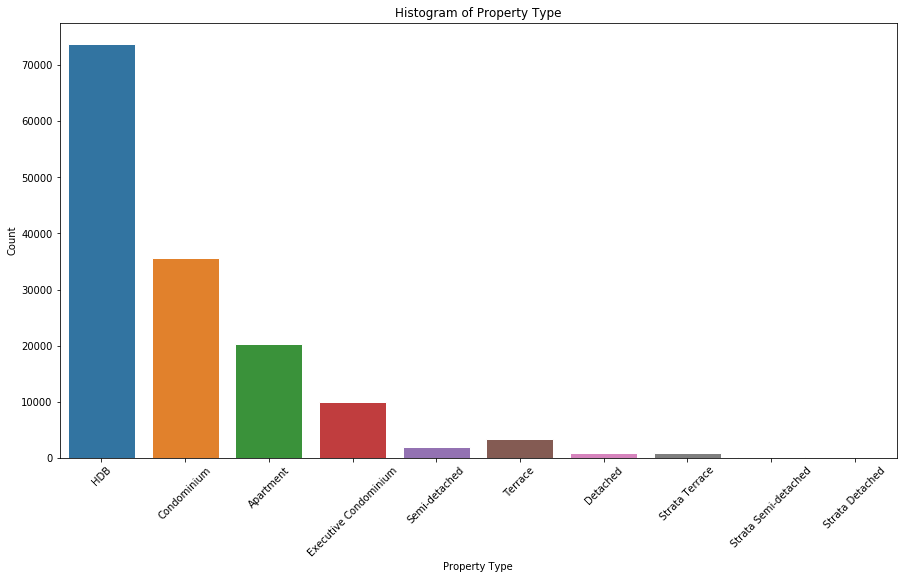

In [51]:
# Plotting histogram for Property Type
plt.figure(figsize=(15, 8))
#plt.hist(x='property_type', data=df_combined, bins = np.arange(11) - 0.5, edgecolor="w")
sns.countplot(df_combined['property_type'], edgecolor="w")

plt.title("Histogram of Property Type")
plt.xlabel("Property Type")
plt.ylabel("Count")
plt.xticks(rotation='45')

plt.show()

Mean Price for  HDB (Thousand):  434
Mean Price for  Condominium (Thousand):  1884
Mean Price for  Apartment (Thousand):  1903
Mean Price for  Executive Condominium (Thousand):  927
Mean Price for  Semi-detached (Thousand):  4405
Mean Price for  Terrace (Thousand):  2823
Mean Price for  Detached (Thousand):  12071
Mean Price for  Strata Terrace (Thousand):  2907
Mean Price for  Strata Semi-detached (Thousand):  3535
Mean Price for  Strata Detached (Thousand):  3705


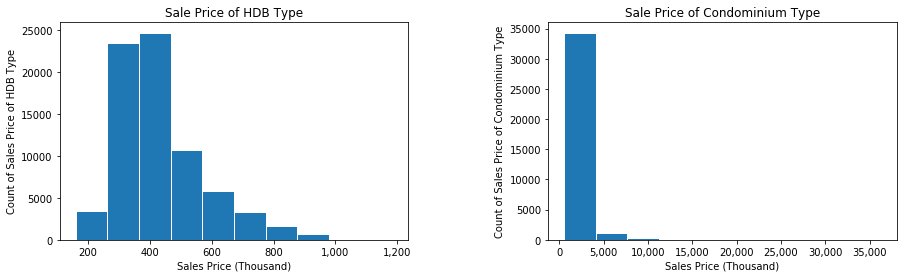

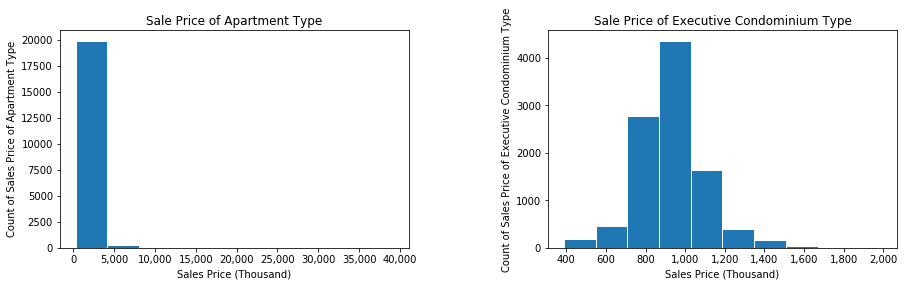

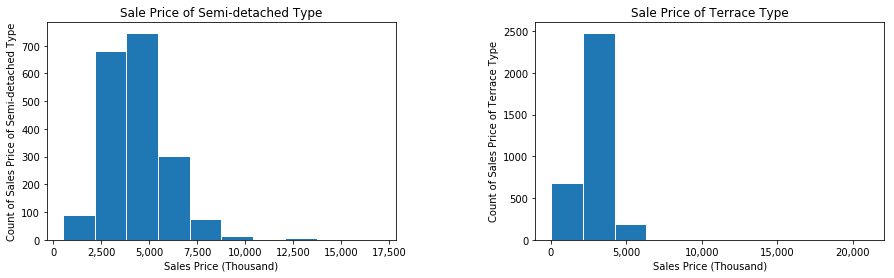

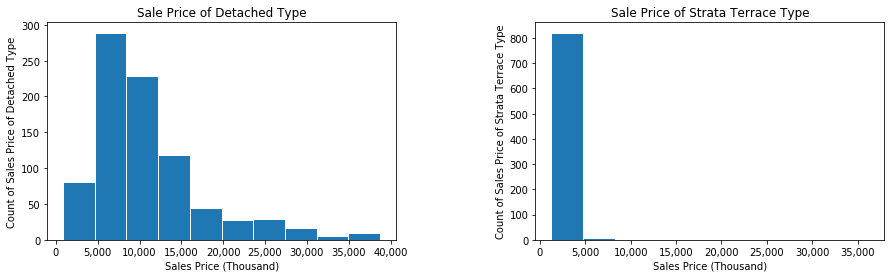

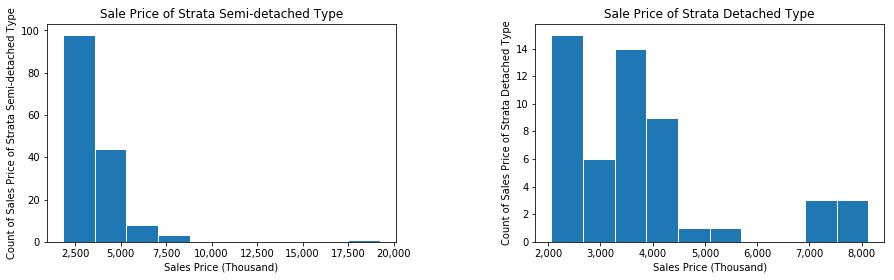

In [52]:
# Plotting histogram for sale price per property type
property_types = list(df_combined.property_type.unique())
pd.set_option('float_format', '{:.0f}'.format)
for p in range(len(property_types)):
    print("Mean Price for ",property_types[p],"(Thousand): ","{:.0f}".format(
        df_combined.loc[df_combined['property_type'] == property_types[p]].adj_saleprice.describe()[1]/1000))
    if (p%2 == 0):
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        fig.subplots_adjust(wspace=.4)
    
    ax[p%2].hist(x=df_combined.loc[(df_combined['property_type'] == property_types[p]) & (
        df_combined['adj_saleprice'] < 40000000)].adj_saleprice/1000, bins=10, edgecolor="w")
    ax[p%2].set_title("Sale Price of "+property_types[p]+" Type")
    ax[p%2].set_xlabel("Sales Price (Thousand)")
    ax[p%2].set_ylabel("Count of Sales Price of "+property_types[p]+" Type")
    ax[p%2].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

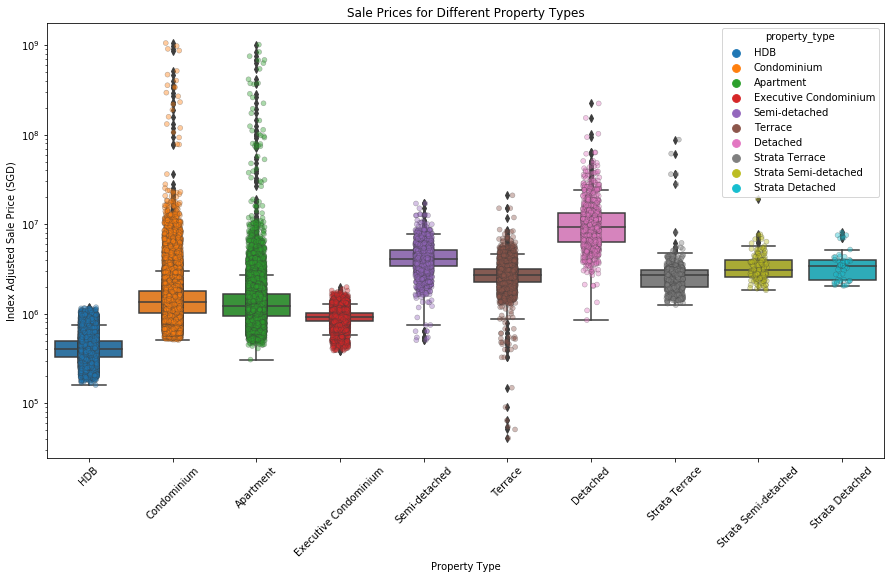

In [53]:
# Plotting boxplots of index adjusted sale price vs property types
plt.figure(figsize=(15, 8))
sns.boxplot(x='property_type', y='adj_saleprice', data=df_combined)
sns.stripplot(x='property_type', y='adj_saleprice', hue='property_type', data=df_combined, 
              jitter=True, alpha=0.4, linewidth=.5)
plt.xlabel("Property Type")
plt.ylabel("Index Adjusted Sale Price (SGD)")
plt.xticks(rotation='45')
plt.yscale("log")
plt.title("Sale Prices for Different Property Types")
plt.show()

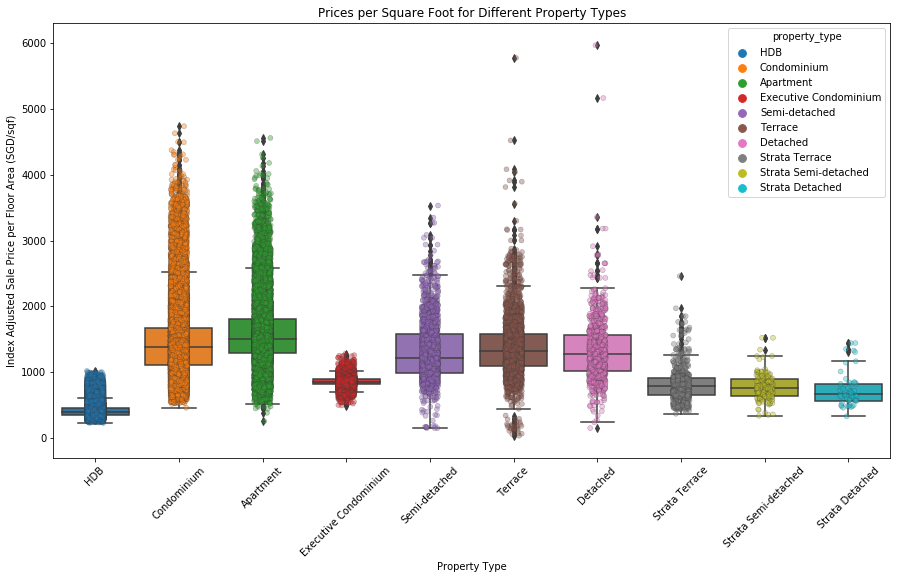

In [54]:
# Plotting boxplots of index adjusted sale price per square meter vs property types
plt.figure(figsize=(15, 8))
sns.boxplot(x='property_type', y=df_combined['adj_salePSF'], data=df_combined)
sns.stripplot(x='property_type', y=df_combined['adj_salePSF'], hue='property_type', data=df_combined, 
              jitter=True, alpha=0.4, linewidth=.5)
plt.xlabel("Property Type")
plt.ylabel("Index Adjusted Sale Price per Floor Area (SGD/sqf)")
plt.xticks(rotation='45')
plt.title("Prices per Square Foot for Different Property Types")

plt.show()

### 3.7 Univariate Analysis: Sales Type

The sales type for properties also has extreme outliers, especially for HDB data.  However, looking at the average,  all the sales type have similar sales price range. 

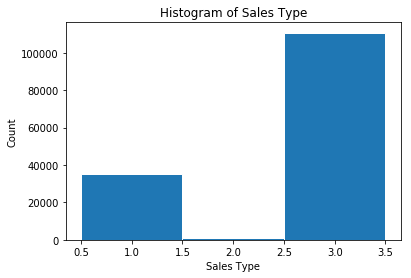

In [55]:
# Plotting histogram for Property Type
plt.figure()
plt.hist(x='type_of_sale', data=df_combined, bins = np.arange(1,5)-0.5, edgecolor="w")
plt.title("Histogram of Sales Type")
plt.xlabel("Sales Type")
plt.ylabel("Count")
plt.show()

Mean Price for  New Sale (Thousand):  1291
Mean Price for  Sub Sale (Thousand):  1112
Mean Price for  Resale (Thousand):  1193


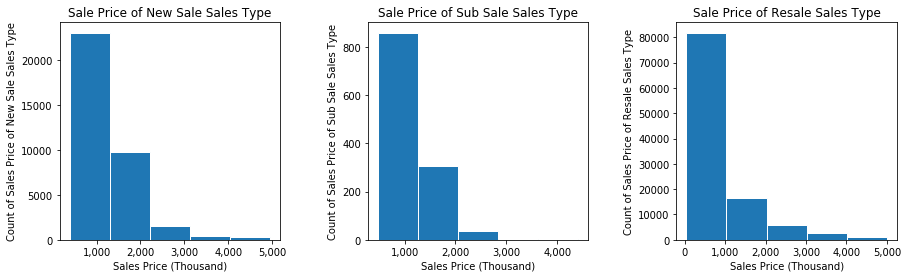

In [56]:
# Plotting histogram for sale price per Sales type
sales_type = ['New Sale','Sub Sale', 'Resale']
fig, ax = plt.subplots(1,3, figsize=(15,4))
fig.subplots_adjust(wspace=.4)
for p in range(3):
    print("Mean Price for ",sales_type[p],"(Thousand): ","{:.0f}".format(df_combined.loc[(df_combined['type_of_sale'] == p+1)].adj_saleprice.describe()[1]/1000))
    ax[p%3].hist(x=df_combined.loc[(df_combined['type_of_sale'] == p+1) & (df_combined['adj_saleprice'] < 5000000)].adj_saleprice/1000, bins=5, edgecolor="w")
    ax[p%3].set_title("Sale Price of "+sales_type[p]+" Sales Type")
    ax[p%3].set_xlabel("Sales Price (Thousand)")
    ax[p%3].set_ylabel("Count of Sales Price of "+sales_type[p]+" Sales Type")
    ax[p%3].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

### 3.8 Univariate Analysis: Lease Commence Date

Lease commence date shows that average sales price of a house which does not have commence date is relatively higher than the once that have some data. Lastly, as lease commence date increase, sales prices increases very slowly.

Text(0,0.5,'Count')

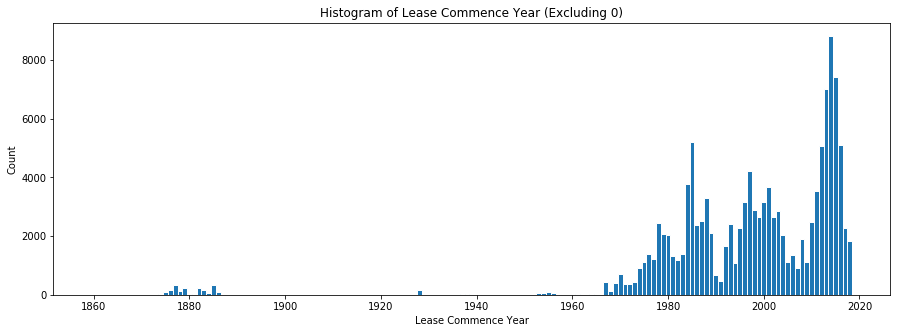

In [57]:
# Plotting histogram for Lease Commence Date
plt.figure(figsize=(15, 5))
plt.hist(x='lease_commence_date', data=df_combined, bins = np.arange(1860,2020)-0.5, edgecolor="w")
plt.title("Histogram of Lease Commence Year (Excluding 0)")
plt.xlabel("Lease Commence Year")
plt.ylabel("Count")

Text(0,0.5,"Index Adjusted Sale Price ('000 SGD)")

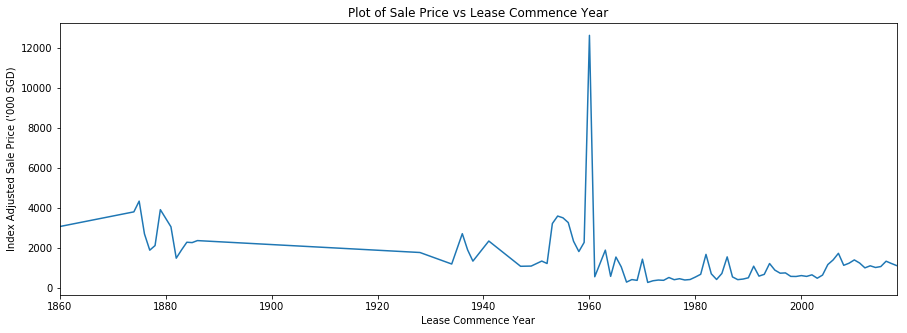

In [58]:
# Plotting Sale Price vs Lease Commence Date
mean_by_commence_date = df_combined[['lease_commence_date', 'adj_saleprice']].groupby(
    'lease_commence_date').mean()/1000
plt.figure(figsize=(15, 5))
mean_by_commence_date = mean_by_commence_date
plt.plot(mean_by_commence_date)
plt.xlim(1860, 2018)
plt.title("Plot of Sale Price vs Lease Commence Year")
plt.xlabel("Lease Commence Year")
plt.ylabel("Index Adjusted Sale Price ('000 SGD)")

In [59]:
print("Mean Price for 0 Commence Date (Thousand): ","{:.0f}".format(
    df_combined.loc[(df_combined['lease_commence_date'] == 0)].adj_saleprice.describe()[1]/1000))

Mean Price for 0 Commence Date (Thousand):  3172


### 3.9 Univariate Analysis: Remaining Lease

Remaining Lease date shows that average sales price of a house whose remaining lease is over 800 have higher price than whose remaining lease is under 100. Within 100 remaining lease, there isn't much difference.

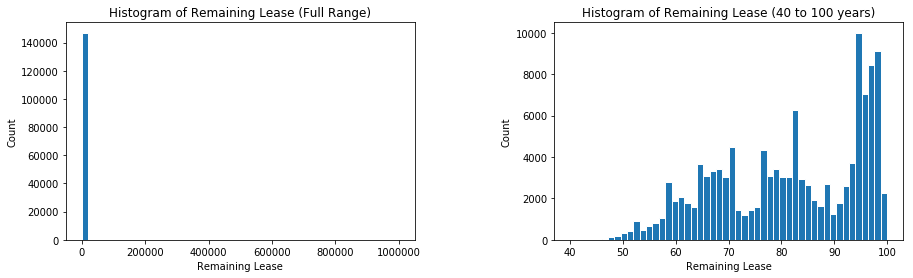

In [60]:
# Plotting histogram for Remaining Lease
fig, ax = plt.subplots(1,2, figsize=(15,4))
fig.subplots_adjust(wspace=.4)

ax[0].hist(x='remaining_lease', data=df_combined, bins=50, edgecolor="w")
ax[0].set_title("Histogram of Remaining Lease (Full Range)")
ax[0].set_xlabel("Remaining Lease")
ax[0].set_ylabel("Count")

ax[1].hist(x='remaining_lease', data=df_combined, bins=50, range=[40,100], edgecolor="w")
ax[1].set_title("Histogram of Remaining Lease (40 to 100 years)")
ax[1].set_xlabel("Remaining Lease")
ax[1].set_ylabel("Count")

plt.show()

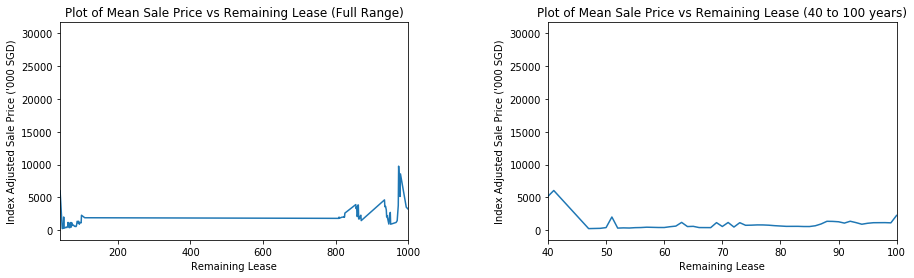

In [61]:
# Plotting Mean Sale Price vs Remaining Lease
fig, ax = plt.subplots(1,2, figsize=(15,4))
fig.subplots_adjust(wspace=.4)

mean_by_remaining_lease = df_combined[['remaining_lease', 'adj_saleprice']].groupby('remaining_lease').mean()/1000

# Plotting for Remaining Lease over all
ax[0].plot(mean_by_remaining_lease)
ax[0].set_title("Plot of Mean Sale Price vs Remaining Lease (Full Range)")
ax[0].set_xlabel("Remaining Lease")
ax[0].set_xlim(40, 1000)
ax[0].set_ylabel("Index Adjusted Sale Price ('000 SGD)")

# Plotting for Remaining Lease under 100
ax[1].plot(mean_by_remaining_lease)
ax[1].set_title("Plot of Mean Sale Price vs Remaining Lease (40 to 100 years)")
ax[1].set_xlabel("Remaining Lease")
ax[1].set_xlim(40, 100)
ax[1].set_ylabel("Index Adjusted Sale Price ('000 SGD)")

plt.show()

In [62]:
print("Mean Price for Remaining Lease over 800 (Thousand): ","{:.0f}".format(
    df_combined.loc[(df_combined['remaining_lease'] > 800)].adj_saleprice.describe()[1]/1000))

print("Mean Price for Remaining Lease under 100 (Thousand): ","{:.0f}".format(
    df_combined.loc[(df_combined['remaining_lease'] < 100)].adj_saleprice.describe()[1]/1000))

Mean Price for Remaining Lease over 800 (Thousand):  3098
Mean Price for Remaining Lease under 100 (Thousand):  851


## 4. Further Data Transforms and Splitting the Dataset

Prior to splitting the dataset into train, development and test set, the columns `property_type` and `type_of_sale` were converted into categories and dummy variables were added. 

The prepared dataset was then split into train, development and test sets in a 74/16/20 split.

In [30]:
df_combined.head()

year_of_sale  month_of_sale    x_location    y_location  storey_level  \
0          2015              1  28478.579445  39676.807613             8   
1          2015              1  30482.026549  39546.884714             2   
2          2015              1  28540.623787  39505.534986             2   
3          2015              1  30452.627801  38865.583668             2   
4          2015              1  30717.373319  39292.930731             8   

   floor_area_sqf property_type  type_of_sale  lease_commence_date  \
0      645.834666           HDB             3                 1986   
1      731.945955           HDB             3                 1981   
2      742.709866           HDB             3                 1980   
3      731.945955           HDB             3                 1979   
4      731.945955           HDB             3                 1980   

   remaining_lease  price_index  adj_saleprice  adj_salePSF  
0               70        135.6  247477.876106   383.190759  
1               65        135.6  266887.905605   364.627885  
2               64        135.6  276592.920354   372.410457  
3               63        135.6  281445.427729   384.516679  
4               64        135.6  281445.427729   384.516679

In [31]:
# Saving a pre-dummy-variable transformed version of the df for later stage...
df_combined_v0 = df_combined.copy(deep=True)

In [32]:
# Creating dummy variables for property type and type of sale
df_combined['property_type'] = df_combined['property_type'].astype('category')
df_combined['property_type'] = df_combined['property_type'].cat.reorder_categories(['HDB', 'Apartment', 'Condominium', 'Detached',
                                                                  'Executive Condominium', 'Semi-detached', 'Strata Detached', 
                                                                  'Strata Semi-detached', 'Strata Terrace', 'Terrace'])
df_combined = pd.get_dummies(df_combined, columns=['property_type'], drop_first=True)
df_combined = pd.get_dummies(df_combined, columns=['type_of_sale'], drop_first=True)

In [33]:
# Creating train, dev and test sets
train_set, test_set = train_test_split(df_combined, test_size=0.2, random_state=0)
train_set, dev_set = train_test_split(train_set, test_size=0.2, random_state=0)

In [34]:
train_set.head()

year_of_sale  month_of_sale    x_location    y_location  storey_level  \
104812          2016             10  32788.185700  37054.929200             3   
72156           2018              9  27458.616133  30064.962427             8   
126394          2018              1  22739.743900  45447.745900             3   
131389          2016              3  18643.767600  40565.384800             8   
144968          2017              9  27858.471735  39691.506272             0   

        floor_area_sqf  lease_commence_date  remaining_lease  price_index  \
104812      914.932444                 2016               99        133.8   
72156       645.834666                 1969               49        131.6   
126394      430.556444                 2011               92        141.6   
131389     1130.210666                 2014               97        136.6   
144968     2207.678168                    0             1000        152.1   

        adj_saleprice       ...        property_type_Condominium  \
104812   1.395484e+06       ...                                1   
72156    3.200000e+05       ...                                0   
126394   5.468432e+05       ...                                1   
131389   9.144619e+05       ...                                0   
144968   3.326726e+06       ...                                0   

        property_type_Detached  property_type_Executive Condominium  \
104812                       0                                    0   
72156                        0                                    0   
126394                       0                                    0   
131389                       0                                    1   
144968                       0                                    0   

        property_type_Semi-detached  property_type_Strata Detached  \
104812                            0                              0   
72156                             0                              0   
126394                            0                              0   
131389                            0                              0   
144968                            0                              0   

        property_type_Strata Semi-detached  property_type_Strata Terrace  \
104812                                   0                             0   
72156                                    0                             0   
126394                                   0                             0   
131389                                   0                             0   
144968                                   0                             0   

        property_type_Terrace  type_of_sale_2  type_of_sale_3  
104812                      0               0               0  
72156                       0               0               1  
126394                      0               0               1  
131389                      0               0               0  
144968                      1               0               1  

[5 rows x 22 columns]

In looking at the labels, the index adjusted sale price had some extreme outliers which would influenced the model results, hence, the decision was to establish two different sets of labels and test which was better for interpretability of results.  The first was the based case index adjusted sale price `adj_saleprice`, and the second is the index adjusted price per square foot `adj_salePSF`.

In [35]:
# Coverting the data frames into input variable arrays and output variable arrays

# Note: 2 types of output variables are established: 1) Price 2) Price per Square Foot

train_labels_p = train_set.pop("adj_saleprice").values
train_labels_psf = train_set.pop("adj_salePSF").values

col_names = train_set.columns
train_set = train_set[train_set.columns].values

dev_labels_p = dev_set.pop("adj_saleprice").values
dev_labels_psf = dev_set.pop("adj_salePSF").values

dev_set = dev_set[dev_set.columns].values

test_labels_p = test_set.pop("adj_saleprice").values
test_labels_psf = test_set.pop("adj_salePSF").values

test_set = test_set[test_set.columns].values

## 5. Modeling and Analysis

### 5.1 Principal Components Analysis

A principal component analysis was performed on the train data, and it found that the ratio of explained variance increases gradually with the number of components.  Given that it would require 16 components to explain for 90% of the variance, it would not be meaningful to perform dimensionality reduction for this dataset.

In [69]:
train_set.shape

(94109, 20)

Running a PCA:


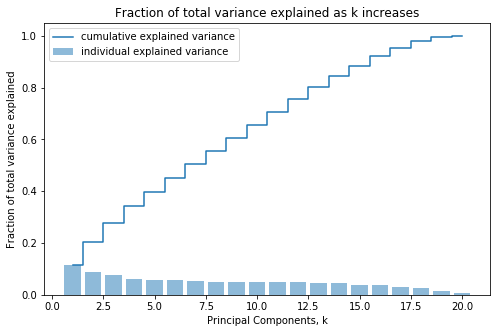

In [70]:
# define the number of principle components
k = train_set.shape[1]

#instantiate StandardScaler and fit_transform (Not Used)
scaler = StandardScaler()
scaled_train_set = scaler.fit_transform(train_set)
    
# instantiate a PCA
pca = PCA(n_components=k)
train_set_pca = pca.fit_transform(scaled_train_set)
#    train_data_pca = pca.fit_transform(scaled_train_data)
explained_var = pca.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)

print("Running a PCA:")

# plotting the PCA with step and bar plot
plt.figure(figsize=(8,5))
plt.bar(x=range(1,k+1), height=explained_var, alpha=0.5, align='center',
         label='individual explained variance')
plt.step(x=range(1,k+1), y=cum_explained_var, where='mid',
         label='cumulative explained variance')
plt.title("Fraction of total variance explained as k increases")
plt.xlabel("Principal Components, k")
plt.ylabel("Fraction of total variance explained")
plt.legend()
plt.show()

### 5.2 Linear Regression

A Linear Regression was to be used as a baseline model for the task. A list of input variables deemed most likely to influence the adjusted price per square foot of a property was setup and we iterated through various combinations of the variables to determine which input variables provided the lowest root mean squared error (RMSE) score when tested against the development data.  Polynomial features were used to improve the results, and the final RMSE score was S\$219 per square foot, which is still relatively large for an accurate prediction. 

The best input variables were found to be the property types, the X and Y coordinates, the storey level, lease commence date and the price index.

In [71]:
def flatten(l): return flatten(l[0]) + (flatten(l[1:]) if len(l) > 1 else []) if type(l) is list else [l]

In [72]:
prop_xs = list(col_names[col_names.str.contains('property_type')])
type_sale_xs = list(col_names[col_names.str.contains('type_of_sale')])

best_rmse = 9999999999999999
best_xs = []

poss_xs = [prop_xs, 'month_of_sale', 'x_location', 'y_location', 'floor_area_sqf', 
           'storey_level', 'lease_commence_date', 'remaining_lease', 'price_index']

# Run through various combinations of possible xs
for i in range(len(poss_xs)):
    for xs in combinations(poss_xs, i + 1):
        xs = flatten(list(xs))
        
        train_xs = train_set[:, col_names.isin(xs)]
        dev_xs = dev_set[:, col_names.isin(xs)]
#         # First linear regression attempt
#         reg = linear_model.LinearRegression()
#         reg.fit(train_xs, y=train_set['adj_saleprice'])
#         dev_xs = np.matrix(dev_xs)
#         reg_pred = reg.predict(dev_xs)
#         rmse_pred = np.sqrt(mean_squared_error(dev_set['adj_saleprice'], reg_pred))
#         print(f'Linear regression w/o polynomial terms: SGD {rmse_pred:,.0f}')

        # Fit with polynomial features
        poly = PolynomialFeatures(3)
        train_xs_poly = poly.fit_transform(train_xs)
        reg = linear_model.LinearRegression(normalize=True)
        reg.fit(train_xs_poly, y=train_labels_psf)
        # Predict using dev set
        dev_xs_poly = poly.transform(dev_xs)
        reg_pred = reg.predict(dev_xs_poly)
        rmse_pred = np.sqrt(mean_squared_error(dev_labels_psf, reg_pred))
        if rmse_pred < best_rmse:
            best_rmse = rmse_pred
            best_xs = xs
            best_pred = reg_pred
            best_reg = reg
            best_poly = poly
            
print(f'Best xs: {xs}')    
print(f'Best RMSE: {best_rmse:,.0f}')

Best xs: ['property_type_Apartment', 'property_type_Condominium', 'property_type_Detached', 'property_type_Executive Condominium', 'property_type_Semi-detached', 'property_type_Strata Detached', 'property_type_Strata Semi-detached', 'property_type_Strata Terrace', 'property_type_Terrace', 'month_of_sale', 'x_location', 'y_location', 'floor_area_sqf', 'storey_level', 'lease_commence_date', 'remaining_lease', 'price_index']
Best RMSE: 218


In [73]:
best_xs

['property_type_Apartment',
 'property_type_Condominium',
 'property_type_Detached',
 'property_type_Executive Condominium',
 'property_type_Semi-detached',
 'property_type_Strata Detached',
 'property_type_Strata Semi-detached',
 'property_type_Strata Terrace',
 'property_type_Terrace',
 'month_of_sale',
 'x_location',
 'y_location',
 'storey_level',
 'lease_commence_date',
 'price_index']

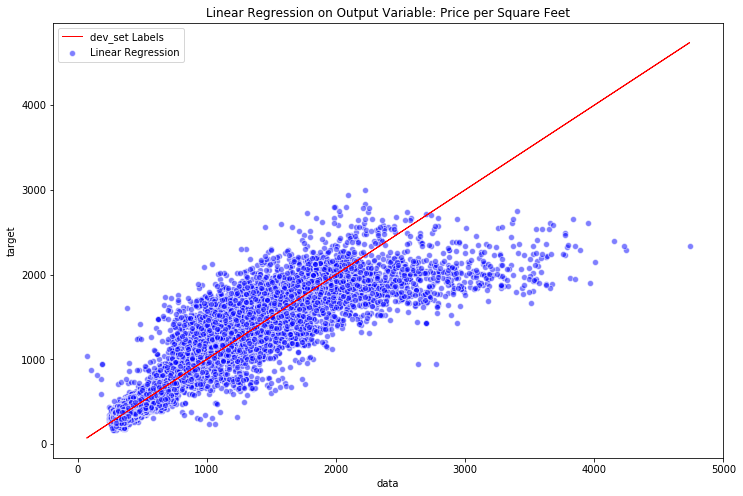

In [74]:
plt.figure(figsize=(12,8))
plt.plot(dev_labels_psf, dev_labels_psf, c="r", label="dev_set Labels", linewidth=1)
plt.scatter(dev_labels_psf, best_pred, c="b", label="Linear Regression", alpha=0.5, edgecolor="w")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Linear Regression on Output Variable: Price per Square Feet")
plt.legend()
plt.show()

### 5.3 Decision Tree

With this initial run using a single decision tree, we saw that the results with sale price being the output variable were not very useful.  The plot of the predicted vs actuals showed that a handful of extreme outliers in the data. The root mean squared error (RSME) at S\$3.8 million was highly influenced by these outliers.  This RMSE value was more than the mean sale price of S$830,910.  Hence we continued the rest of the analysis using the price per square foot as the alternate output variable instead.

Using a Decision Tree Regressor and Output Variable Price...
R-square Coefficient: 0.85
Root Mean Squared Error: 3766940


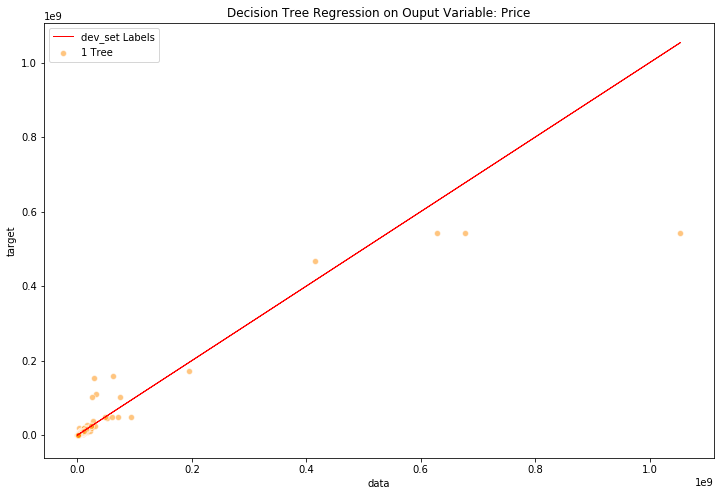

In [72]:
# Using decision tree regressor with output variable as Price

dt_p = DecisionTreeRegressor(criterion='mse', splitter="best", random_state=0)
dt_p.fit(train_set, train_labels_p)

print ('Using a Decision Tree Regressor and Output Variable Price...')
print ('R-square Coefficient: {:.2f}'.format(dt_p.score(dev_set, dev_labels_p)))

dev_predicted_p = dt_p.predict(dev_set)

print ('Root Mean Squared Error: {:.0f}'.format(np.sqrt(mean_squared_error(dev_labels_p, dev_predicted_p))))

plt.figure(figsize=(12,8))
plt.plot(dev_labels_p, dev_labels_p, c="r", label="dev_set Labels", linewidth=1)
plt.scatter(dev_labels_p, dev_predicted_p, c="darkorange", label="1 Tree", alpha=0.5, edgecolor="w")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression on Ouput Variable: Price")
plt.legend()
plt.show()

Using a Decision Tree Regressor and Output Variable Price per Square Feet...
R-square Coefficient: 0.97
Root Mean Squared Error: 106


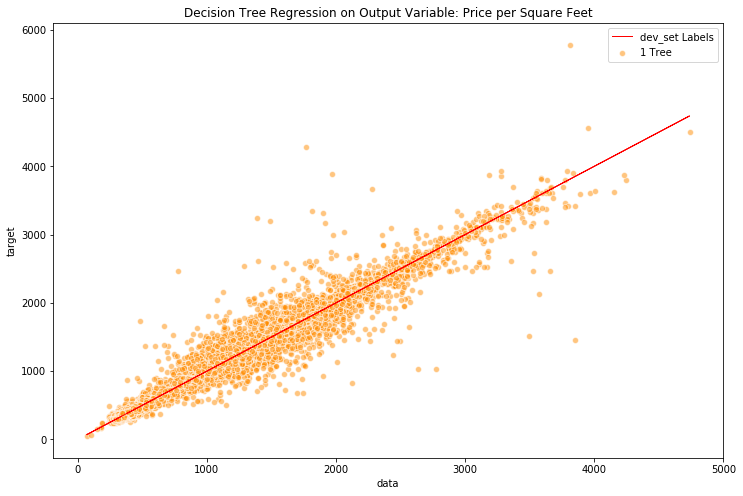

In [36]:
# Using decision tree regressor with output variable as Price per Square Feet

dt_psf = DecisionTreeRegressor(criterion='mse', splitter="best", random_state=0)
dt_psf.fit(train_set, train_labels_psf)

print ('Using a Decision Tree Regressor and Output Variable Price per Square Feet...')
print ('R-square Coefficient: {:.2f}'.format(dt_psf.score(dev_set, dev_labels_psf)))

dev_predicted_psf = dt_psf.predict(dev_set)

print ('Root Mean Squared Error: {:.0f}'.format(np.sqrt(mean_squared_error(dev_labels_psf, dev_predicted_psf))))

plt.figure(figsize=(12,8))
plt.plot(dev_labels_psf, dev_labels_psf, c="r", label="dev_set Labels", linewidth=1)
plt.scatter(dev_labels_psf, dev_predicted_psf, c="darkorange", label="1 Tree", alpha=0.5, edgecolor="w")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression on Output Variable: Price per Square Feet")
plt.legend()
plt.show()

### 5.3.1 Decision Trees with AdaBoost

With the better results from a single Decision Tree, the next model we implemented was a Decision Trees with Adaptive Boosting, or AdaBoost.  The results seem to improve further with some iteration of parameters, specifically the number of estimators and the loss function. Results of RMSE of below S$100 per square foot is very promising.

Using an AdaBoost Decision Tree Regressor and Output Variable Price per Square Feet...
R-square Coefficient: 0.98
Root Mean Squared Error: 83


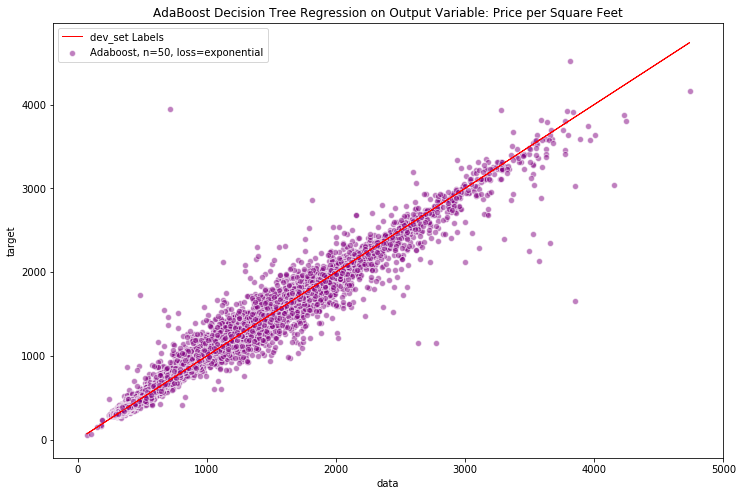

In [37]:
# Using Adaboost with decision tree regressor with output variable as Price per Square Feet

abdt_psf = AdaBoostRegressor(DecisionTreeRegressor(criterion='mse', splitter="best"),
                             n_estimators=50, loss='exponential', random_state=0)
abdt_psf.fit(train_set, train_labels_psf)

print ('Using an AdaBoost Decision Tree Regressor and Output Variable Price per Square Feet...')
print ('R-square Coefficient: {:.2f}'.format(abdt_psf.score(dev_set, dev_labels_psf)))

dev_abdt_predicted_psf = abdt_psf.predict(dev_set)

print ('Root Mean Squared Error: {:.0f}'.format(np.sqrt(mean_squared_error(dev_labels_psf, dev_abdt_predicted_psf))))

plt.figure(figsize=(12,8))
plt.plot(dev_labels_psf, dev_labels_psf, c="r", label="dev_set Labels", linewidth=1)
plt.scatter(dev_labels_psf, dev_abdt_predicted_psf, c="purple", label="Adaboost, n=50, loss=exponential", alpha=0.5, edgecolor="w")
plt.xlabel("data")
plt.ylabel("target")
plt.title("AdaBoost Decision Tree Regression on Output Variable: Price per Square Feet")
plt.legend()
plt.show()

### 5.3.2 Decision Trees with AdaBoost and Grid Search CV

Building on the results of AdaBoost Decision Trees, GridSearchCV was used to iterate hyper parameters across 5-fold cross validation. The best hyper parameters for the AdaBoost Decision Trees model.  In re-running the AdaBoost Decision Trees model with the tuned hyper parameters, we achieved a better result of a RMSE of S$82 per square foot.

In [75]:
param_grid_abdt = [
    {'n_estimators': [10, 30, 50, 70], 'loss': ['linear', 'square', 'exponential']}]

grid_search_abdt = GridSearchCV(abdt_psf, param_grid_abdt, cv=5,
                           scoring='neg_mean_squared_error')

grid_search_abdt.fit(train_set, train_labels_psf)

GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='exponential', n_estimators=50,
         random_state=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 30, 50, 70], 'loss': ['linear', 'square', 'exponential']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [77]:
grid_search_abdt.best_params_

{'loss': 'square', 'n_estimators': 70}

In [78]:
cvres_abdt = grid_search_abdt.cv_results_
for mean_score, params in zip(cvres_abdt["mean_test_score"], cvres_abdt["params"]):
    print(np.sqrt(-mean_score), params)

90.19101200087685 {'loss': 'linear', 'n_estimators': 10}
85.6212955760843 {'loss': 'linear', 'n_estimators': 30}
84.59456501840295 {'loss': 'linear', 'n_estimators': 50}
84.8309471121962 {'loss': 'linear', 'n_estimators': 70}
89.03162884246575 {'loss': 'square', 'n_estimators': 10}
84.71257262986008 {'loss': 'square', 'n_estimators': 30}
83.83478739789545 {'loss': 'square', 'n_estimators': 50}
83.48515983200937 {'loss': 'square', 'n_estimators': 70}
89.38586766409863 {'loss': 'exponential', 'n_estimators': 10}
85.3245960915053 {'loss': 'exponential', 'n_estimators': 30}
84.38721132476195 {'loss': 'exponential', 'n_estimators': 50}
84.62442720187808 {'loss': 'exponential', 'n_estimators': 70}


Using an AdaBoost Decision Tree Regressor with Hyper Parameter Tuning and Output Variable Price per Square Feet...
R-square Coefficient: 0.98
Root Mean Squared Error: 82


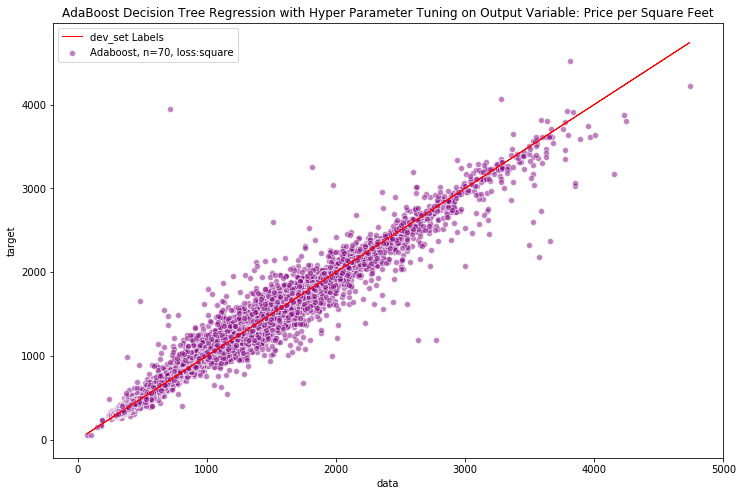

In [82]:
# Using Adaboost with decision tree regressor with Grid Search CV tuned hyper parameters

abdt_psf = AdaBoostRegressor(DecisionTreeRegressor(criterion='mse', splitter="best"),
                             n_estimators=grid_search_abdt.best_params_['n_estimators'],
                             loss=grid_search_abdt.best_params_['loss'], random_state=0)
abdt_psf.fit(train_set, train_labels_psf)

print ('Using an AdaBoost Decision Tree Regressor with Hyper Parameter Tuning and Output Variable Price per Square Feet...')
print ('R-square Coefficient: {:.2f}'.format(abdt_psf.score(dev_set, dev_labels_psf)))

dev_abdt_predicted_psf = abdt_psf.predict(dev_set)

print ('Root Mean Squared Error: {:.0f}'.format(np.sqrt(mean_squared_error(dev_labels_psf, dev_abdt_predicted_psf))))

plt.figure(figsize=(12,8))
plt.plot(dev_labels_psf, dev_labels_psf, c="r", label="dev_set Labels", linewidth=1)
plt.scatter(dev_labels_psf, dev_abdt_predicted_psf, c="purple", 
            label="Adaboost, n=" + str(grid_search_abdt.best_params_['n_estimators']) + 
            ", loss:" + str(grid_search_abdt.best_params_['loss']), 
            alpha=0.5, edgecolor="w")
plt.xlabel("data")
plt.ylabel("target")
plt.title("AdaBoost Decision Tree Regression with Hyper Parameter Tuning on Output Variable: Price per Square Feet")
plt.legend()
plt.show()

### 5.4 Random Forest

Expanding further on ensemble methods based on decision trees, we implemented a random forest model.  The first attempt was encouraging with a RMSE of less the S$100 per square foot.

Using a Random Forest Regressor and Output Variable Price per Square Feet...
R-square Coefficient: 0.98
Root Mean Squared Error: 86


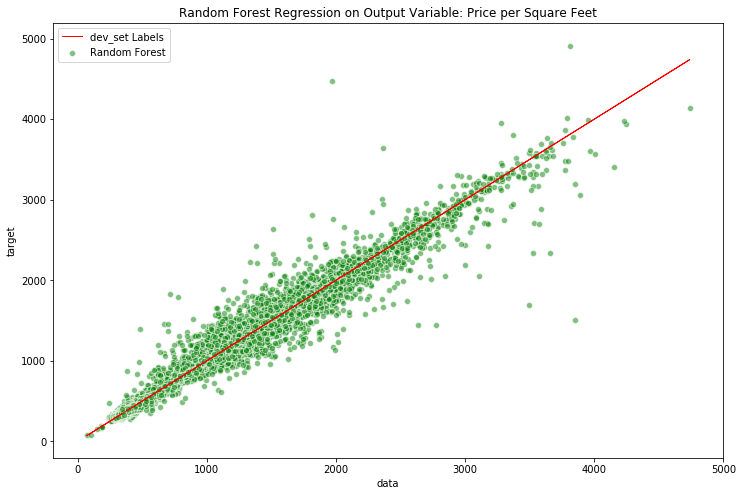

In [96]:
# Using Random Forest with output variable as Price per Square Feet

forest_reg = RandomForestRegressor()
forest_reg.fit(train_set, y=train_labels_psf)

print ('Using a Random Forest Regressor and Output Variable Price per Square Feet...')
print ('R-square Coefficient: {:.2f}'.format(forest_reg.score(dev_set, dev_labels_psf)))

dev_forest_predicted_psf = forest_reg.predict(dev_set)

print ('Root Mean Squared Error: {:.0f}'.format(np.sqrt(mean_squared_error(dev_labels_psf, dev_forest_predicted_psf))))

plt.figure(figsize=(12,8))
plt.plot(dev_labels_psf, dev_labels_psf, c="r", label="dev_set Labels", linewidth=1)
plt.scatter(dev_labels_psf, dev_forest_predicted_psf, c="g", label="Random Forest", alpha=0.5, edgecolor="w")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Random Forest Regression on Output Variable: Price per Square Feet")
plt.legend()
plt.show()

### 5.4.1 Random Forest with Grid Search CV

Utilizing GridSearchCV to iterate hyper parameters across 5-fold cross validation, we attained the best hyper parameters for the random forest model.  In re-running the random forest model with the tuned hyper parameters, we achieved the best result thus far of a RMSE of S$81 per square foot.

In [84]:
param_grid = [
    {'n_estimators': [3, 10, 30, 50], 'max_features': [2, 4, 6, 8, 10]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')

grid_search.fit(train_set, train_labels_psf)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30, 50], 'max_features': [2, 4, 6, 8, 10]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [85]:
grid_search.best_params_

{'max_features': 10, 'n_estimators': 50}

In [86]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

144.08554866727317 {'max_features': 2, 'n_estimators': 3}
119.24385344692327 {'max_features': 2, 'n_estimators': 10}
113.77375599086767 {'max_features': 2, 'n_estimators': 30}
112.39117193927605 {'max_features': 2, 'n_estimators': 50}
125.68160082699148 {'max_features': 4, 'n_estimators': 3}
106.17909465420276 {'max_features': 4, 'n_estimators': 10}
99.4938121088273 {'max_features': 4, 'n_estimators': 30}
99.0220833658808 {'max_features': 4, 'n_estimators': 50}
112.57877125066584 {'max_features': 6, 'n_estimators': 3}
97.80942763572841 {'max_features': 6, 'n_estimators': 10}
92.2217556140227 {'max_features': 6, 'n_estimators': 30}
90.99768455350286 {'max_features': 6, 'n_estimators': 50}
106.48248988368617 {'max_features': 8, 'n_estimators': 3}
92.99188590872512 {'max_features': 8, 'n_estimators': 10}
87.92431490084542 {'max_features': 8, 'n_estimators': 30}
86.99010483441471 {'max_features': 8, 'n_estimators': 50}
103.79125038769799 {'max_features': 10, 'n_estimators': 3}
89.185495790

Using a Random Forest Regressor with Hyper Parameter Tuning and Output Variable Price per Square Feet...
R-square Coefficient: 0.98
Root Mean Squared Error: 81


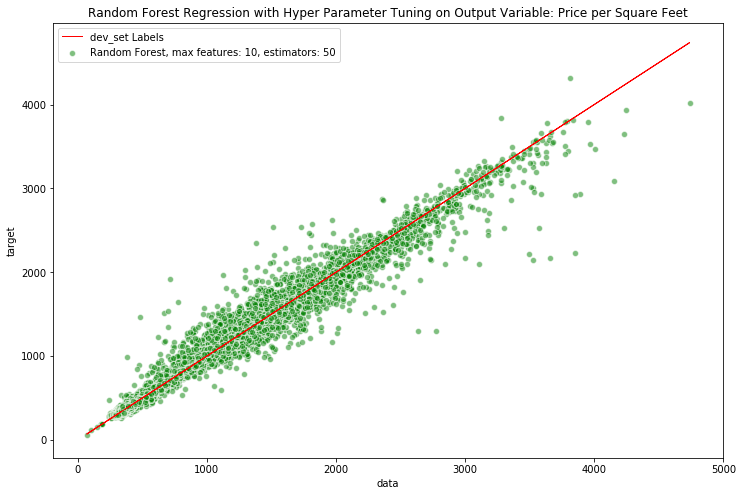

In [87]:
# Using Random Forest with new hyperparameters from GridSearch CV, output variable as Price per Square Feet

forest_reg = RandomForestRegressor(max_features=grid_search.best_params_['max_features'],
                                   n_estimators=grid_search.best_params_['n_estimators'])
forest_reg.fit(train_set, y=train_labels_psf)

print ('Using a Random Forest Regressor with Hyper Parameter Tuning and Output Variable Price per Square Feet...')
print ('R-square Coefficient: {:.2f}'.format(forest_reg.score(dev_set, dev_labels_psf)))

dev_forest_predicted_psf = forest_reg.predict(dev_set)

print ('Root Mean Squared Error: {:.0f}'.format(np.sqrt(mean_squared_error(dev_labels_psf, dev_forest_predicted_psf))))

plt.figure(figsize=(12,8))
plt.plot(dev_labels_psf, dev_labels_psf, c="r", label="dev_set Labels", linewidth=1)
plt.scatter(dev_labels_psf, dev_forest_predicted_psf, c="g", 
            label="Random Forest, max features: " + str(grid_search.best_params_['max_features']) + 
            ", estimators: " + str(grid_search.best_params_['n_estimators']),
            alpha=0.5, edgecolor="w")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Random Forest Regression with Hyper Parameter Tuning on Output Variable: Price per Square Feet")
plt.legend()
plt.show()

### 5.4.2 Random Forest on dataset without landed properties

It was observed that accuracy improved when running the Random Forest model on the dataset without landed properties.  This supports the earlier intuition that outliers, which is more likely observed from landed properties, do impact the model's performance.  Excluding landed properties from the model improves accuracy but at the expense of limiting the scope of the model/ project. 

In [277]:
# Recreating the dataset but without landed properties

df_combinedx = df_combined_v0.copy(deep=True)
df_combinedx = df_combinedx[(df_combinedx['property_type']=='HDB')
                            | (df_combinedx['property_type']=='Apartment') 
                            | (df_combinedx['property_type']=='Condominium') 
                            | (df_combinedx['property_type']=='Executive Condominium')]
df_combinedx['property_type'] = df_combinedx['property_type'].astype('category')
df_combinedx['property_type'] = df_combinedx['property_type'].cat.reorder_categories(['HDB', 'Apartment', 'Condominium', 'Executive Condominium'])
df_combinedx = pd.get_dummies(df_combinedx, columns=['property_type'], drop_first=True)
df_combinedx = pd.get_dummies(df_combinedx, columns=['type_of_sale'], drop_first=True)
train_set, test_set = train_test_split(df_combinedx, test_size=0.2, random_state=0)
train_set, dev_set = train_test_split(train_set, test_size=0.2, random_state=0)
# Coverting the data frames into input variable arrays and output variable arrays

# Note: 2 types of output variables are established: 1) Price 2) Price per Square Foot

train_labels_p = train_set.pop("adj_saleprice").values
train_labels_psf = train_set.pop("adj_salePSF").values

train_set = train_set[train_set.columns].values

dev_labels_p = dev_set.pop("adj_saleprice").values
dev_labels_psf = dev_set.pop("adj_salePSF").values

dev_set = dev_set[dev_set.columns].values

test_labels_p = test_set.pop("adj_saleprice").values
test_labels_psf = test_set.pop("adj_salePSF").values

test_set = test_set[test_set.columns].values

Using a Random Forest Regressor and Output Variable Price per Square Feet...
R-square Coefficient: 0.99
Root Mean Squared Error: 71


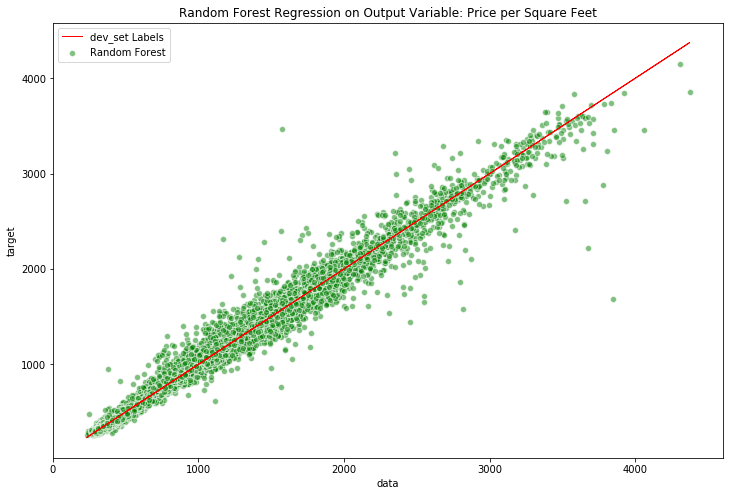

In [73]:
# Rerunning Random Forest on the dataset without landed properties

forest_reg = RandomForestRegressor()
forest_reg.fit(train_set, y=train_labels_psf)

print ('Using a Random Forest Regressor and Output Variable Price per Square Feet...')
print ('R-square Coefficient: {:.2f}'.format(forest_reg.score(dev_set, dev_labels_psf)))

dev_forest_predicted_psf = forest_reg.predict(dev_set)

print ('Root Mean Squared Error: {:.0f}'.format(np.sqrt(mean_squared_error(dev_labels_psf, dev_forest_predicted_psf))))

plt.figure(figsize=(12,8))
plt.plot(dev_labels_psf, dev_labels_psf, c="r", label="dev_set Labels", linewidth=1)
plt.scatter(dev_labels_psf, dev_forest_predicted_psf, c="g", label="Random Forest", alpha=0.5, edgecolor="w")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Random Forest Regression on Output Variable: Price per Square Feet")
plt.legend()
plt.show()

### 5.5 Additional Analysis: K-Means Clustering

An additional K-Means clustering was fitted to the dataset to see if there are discernable clusters in the data.  A range from 2 to 21 clusters were iterated through and the resultant silhouette scores were attained.  None of the silhouette scores for the number of clusters tested were greater than 0.5 and the max was 0.288 at 9 clusters.  It does seem that the data is more likely to have either 2 or 9 occuring clusters.

In [38]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

Note: Clustering is done without adj_psf and price in order to prevent issues with testing of predictions later on

In [39]:
col_names

Index(['year_of_sale', 'month_of_sale', 'x_location', 'y_location',
       'storey_level', 'floor_area_sqf', 'lease_commence_date',
       'remaining_lease', 'price_index', 'property_type_Apartment',
       'property_type_Condominium', 'property_type_Detached',
       'property_type_Executive Condominium', 'property_type_Semi-detached',
       'property_type_Strata Detached', 'property_type_Strata Semi-detached',
       'property_type_Strata Terrace', 'property_type_Terrace',
       'type_of_sale_2', 'type_of_sale_3'],
      dtype='object')

In [40]:
# Scaling the values by the scale function which subtracts the mean and normalizes by std dev
df_scaled = scale(df_combined.loc[:,col_names])

In [105]:
# Iterating through a range of clusters 2 to 21, 
# finding the KMeans and getting the silhouette scores
np.random.seed(123)
sil_scores = pd.DataFrame(columns=['clusters', 'silhouette'], dtype=float)

for i in range(20):
    i += 2
    kmm = KMeans(n_clusters=i)
    cluster_labels = kmm.fit_predict(df_scaled)
    sil = silhouette_score(df_scaled, cluster_labels, sample_size=10000)
    sil_scores = pd.concat([sil_scores, pd.DataFrame (
        {'clusters': [i], 'silhouette': [sil]})], axis=0)

sil_scores.reset_index(drop=True, inplace=True)

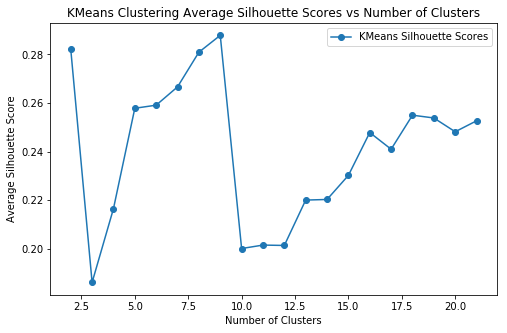

Max Average Silhouette Score is 0.288


In [104]:
# plotting the silhouette scores
plt.figure(figsize=(8,5))
plt.plot(sil_scores.clusters, sil_scores.silhouette, 'o-',
         label='KMeans Silhouette Scores')
plt.title("KMeans Clustering Average Silhouette Scores vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Score")
plt.legend()
plt.show()

print("Max Average Silhouette Score is {:.3f}".format(
    sil_scores.silhouette.max()))

Try 2 clusters as suggested by silhouette scores

In [41]:
np.random.seed(123)
kmm = KMeans(n_clusters=2)
cluster_labels = kmm.fit_predict(df_scaled[:,])

In [42]:
pd.set_option("max_columns",100)

In [43]:
pd.DataFrame([df_combined[cluster_labels == 0].mean(), df_combined[cluster_labels == 1].mean()])

year_of_sale  month_of_sale    x_location    y_location  storey_level  \
0   2016.504945       6.424139  28515.845896  39128.789163      8.374683   
1   2017.054272       6.399416  30209.282185  34715.945476      9.430994   

   floor_area_sqf  lease_commence_date  remaining_lease  price_index  \
0     1063.223030          1994.236518        82.069772   134.077460   
1     1540.342116          1268.289230       490.593757   140.589839   

   adj_saleprice  adj_salePSF  property_type_Apartment  \
0   5.330437e+05   502.353806                 0.009833   
1   2.267772e+06  1509.967537                 0.335154   

   property_type_Condominium  property_type_Detached  \
0                   0.049837                0.000000   
1                   0.540401                0.014916   

   property_type_Executive Condominium  property_type_Semi-detached  \
0                              0.11267                     0.000000   
1                              0.00000                     0.033168   

   property_type_Strata Detached  property_type_Strata Semi-detached  \
0                       0.000000                            0.000000   
1                       0.000899                            0.002662   

   property_type_Strata Terrace  property_type_Terrace  type_of_sale_2  \
0                      0.000000               0.000000        0.000000   
1                      0.014415               0.058385        0.020896   

   type_of_sale_3  
0        0.896614  
1        0.531137

The clusters are then joined back into a copy of the original combined dataset to see their attributes

In [44]:
df_clust = df_combined.copy()
df_clust['cluster'] = cluster_labels
df_clust['property'] = df_clust.loc[:,df_clust.columns.str.contains('property_type')].sum(axis=1)
df_clust['property'] = np.where(df_clust['property']==1, 'private', 'public')

Using 2 clusters appears to split dataset into primarily:  
1. Cluster 0: Public housing  
2. Cluster 1: Private housing

Text(0.5,1,'Private/Public by cluster')

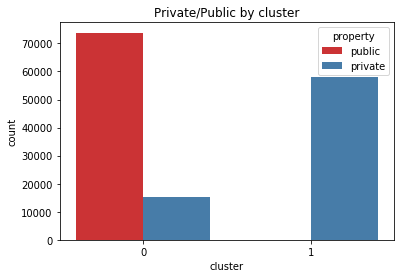

In [45]:
sns.countplot(x="cluster", hue="property", data=df_clust, palette="Set1").set_title('Private/Public by cluster')

Text(0.5,1,'Adjusted psf by cluster')

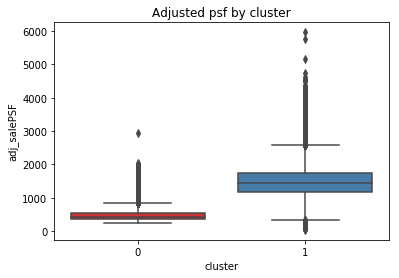

In [46]:
sns.boxplot(x="cluster", y="adj_salePSF", data=df_clust, palette="Set1").set_title('Adjusted psf by cluster')

Attempt to rerun random forest using pre-clustering

In [342]:
np.random.seed(123)
kmm = KMeans(n_clusters=2)
cluster_labels = kmm.fit_predict(df_scaled[:,])

In [80]:
# Creating train, dev and test sets
df_combined2 = df_combined.loc[:,df_combined.columns.drop(['adj_saleprice'])].copy(deep=True)
df_combined2['cluster'] = cluster_labels
train_set, test_set = train_test_split(df_combined2, test_size=0.2, random_state=0)
train_set, dev_set = train_test_split(train_set, test_size=0.2, random_state=0)

train_labels_psf = train_set.pop("adj_salePSF").values
train_set = train_set[train_set.columns].values

dev_labels_psf = dev_set.pop("adj_salePSF").values
dev_set = dev_set[dev_set.columns].values

test_labels_psf = test_set.pop("adj_salePSF").values
test_set = test_set[test_set.columns].values

In [53]:
# Rerunning Random Forest on the dataset, split on clusters

forest_reg0 = RandomForestRegressor(n_estimators=1000, max_features='auto', n_jobs=-1)
forest_reg0.fit(train_set[train_set[:,-1] == 0], y=train_labels_psf[train_set[:,-1] == 0])

forest_reg1 = RandomForestRegressor(n_estimators=1000, max_features='auto', n_jobs=-1)
forest_reg1.fit(train_set[train_set[:,-1] == 1], y=train_labels_psf[train_set[:,-1] == 1])

dev_forest_predicted_psf0 = forest_reg0.predict(dev_set[dev_set[:,-1] == 0])
dev_forest_predicted_psf1 = forest_reg1.predict(dev_set[dev_set[:,-1] == 1])

In [55]:
dev_psf = np.append(dev_labels_psf[dev_set[:,-1] == 0], dev_labels_psf[dev_set[:,-1] == 1])
dev_pred_psf = np.append(dev_forest_predicted_psf0, dev_forest_predicted_psf1)

In [56]:
print ('Root Mean Squared Error: {:.0f}'.format(np.sqrt(mean_squared_error(dev_psf, dev_pred_psf))))

Root Mean Squared Error: 80


Improvement after splitting by clusters first is marginal, attempt using AdaBoost

In [87]:
# Rerunning AdaBoost on the dataset, split on clusters
ada_reg0 = AdaBoostRegressor(DecisionTreeRegressor(criterion='mse', splitter="best"),
                             n_estimators=70,
                             loss='square', random_state=0)
ada_reg0.fit(train_set[train_set[:,-1] == 0], y=train_labels_psf[train_set[:,-1] == 0])

ada_reg1 = AdaBoostRegressor(DecisionTreeRegressor(criterion='mse', splitter="best"),
                             n_estimators=70,
                             loss='square', random_state=0)
ada_reg1.fit(train_set[train_set[:,-1] == 1], y=train_labels_psf[train_set[:,-1] == 1])

dev_ada_predicted_psf0 = ada_reg0.predict(dev_set[dev_set[:,-1] == 0])
dev_ada_predicted_psf1 = ada_reg1.predict(dev_set[dev_set[:,-1] == 1])

In [88]:
dev_ada_pred_psf = np.append(dev_ada_predicted_psf0, dev_ada_predicted_psf1)

In [89]:
print ('Root Mean Squared Error: {:.0f}'.format(np.sqrt(mean_squared_error(dev_psf, dev_ada_pred_psf))))

Root Mean Squared Error: 81


In [90]:
print ('Root Mean Squared Error: {:.0f}'.format(np.sqrt(mean_squared_error(dev_psf, 0.5*dev_pred_psf + 0.5*dev_ada_pred_psf))))

Root Mean Squared Error: 78


Averaging the models appears to provide some benefit

Attempt using XGboost

In [91]:
import xgboost as xgb

In [92]:
xgb_reg0 = xgb.XGBRegressor(n_estimators=2000, max_depth=10, n_jobs=-1)
xgb_reg0.fit(train_set[train_set[:,-1] == 0], y=train_labels_psf[train_set[:,-1] == 0])

xgb_reg1 = xgb.XGBRegressor(n_estimators=2000, max_depth=10, n_jobs=-1)
xgb_reg1.fit(train_set[train_set[:,-1] == 1], y=train_labels_psf[train_set[:,-1] == 1])

dev_xgb_predicted_psf0 = xgb_reg0.predict(dev_set[dev_set[:,-1] == 0])
dev_xgb_predicted_psf1 = xgb_reg1.predict(dev_set[dev_set[:,-1] == 1])

In [93]:
dev_xgb_pred_psf = np.append(dev_xgb_predicted_psf0, dev_xgb_predicted_psf1)

In [94]:
print ('Root Mean Squared Error: {:.0f}'.format(np.sqrt(mean_squared_error(dev_psf, dev_xgb_pred_psf))))

Root Mean Squared Error: 79


In [103]:
dev_ensemble_pred_psf = 1/3*dev_pred_psf + 1/3*dev_ada_pred_psf + 1/3*dev_xgb_pred_psf

In [104]:
print ('Root Mean Squared Error: {:.0f}'.format(np.sqrt(mean_squared_error(dev_psf, dev_ensemble_pred_psf))))

Root Mean Squared Error: 76


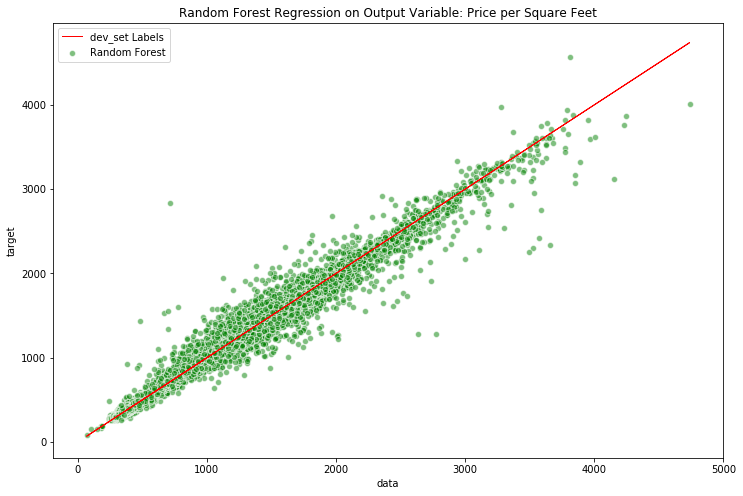

In [101]:
plt.figure(figsize=(12,8))
plt.plot(dev_psf, dev_psf, c="r", label="dev_set Labels", linewidth=1)
plt.scatter(dev_psf, ensemble_psf, c="g", label="Random Forest", alpha=0.5, edgecolor="w")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Random Forest Regression on Output Variable: Price per Square Feet")
plt.legend()
plt.show()

After using separate clusters, RMSE improves to 76. This lowered RMSE carries over to the final test with the testing set

In [105]:
test_forest_predicted_psf0 = forest_reg0.predict(test_set[test_set[:,-1] == 0])
test_forest_predicted_psf1 = forest_reg1.predict(test_set[test_set[:,-1] == 1])

test_ada_predicted_psf0 = ada_reg0.predict(test_set[test_set[:,-1] == 0])
test_ada_predicted_psf1 = ada_reg1.predict(test_set[test_set[:,-1] == 1])

test_xgb_predicted_psf0 = xgb_reg0.predict(test_set[test_set[:,-1] == 0])
test_xgb_predicted_psf1 = xgb_reg1.predict(test_set[test_set[:,-1] == 1])

In [106]:
test_psf = np.append(test_labels_psf[test_set[:,-1] == 0], test_labels_psf[test_set[:,-1] == 1])

test_forest_pred_psf = np.append(test_forest_predicted_psf0, test_forest_predicted_psf1)
test_ada_pred_psf = np.append(test_ada_predicted_psf0, test_ada_predicted_psf1)
test_xgb_pred_psf = np.append(test_xgb_predicted_psf0, test_xgb_predicted_psf1)

In [108]:
test_ensemble_pred_psf = 1/3*test_forest_pred_psf + 1/3*test_ada_pred_psf + 1/3*test_xgb_pred_psf

In [109]:
print ('Root Mean Squared Error: {:.0f}'.format(np.sqrt(mean_squared_error(test_psf, test_ensemble_pred_psf))))

Root Mean Squared Error: 76


## 6. Conclusions

The project required collection and integrating datasets from various sources including the URA website, the data.gov.sg website, as well as mapping addresses into X,Y coordinates with the OneMap API. Further transformations of the data was done to preprocess the data into a suitable form for machine learning to be applied. The resultant dataset was trained against a number of models (including Linear Regression, Decision Tree, AdaBoost Decision Trees, and Random Forest) and tested against the developmental data in terms of RMSE (root mean squared error). In the analysis process, further iterative changes were made to allow for a more interpretable model and better results, such as the decision to use an index adjusted price per floor area instead of just the price of the home.  The results of have a tuned Random Forest model which has a RSME of S\$81 per square foot, and if the dataset is further pre-clustered into public housing and private housing, the predictions from the averaged predictions are improved to S\$76 per square foot on the development set. The final results with pre-clustering and random forest, AdaBoost and XGboost on the test set have a final RSME of S\$76 per square foor. Considering the current mean price per square foot for a home in Singapore is close to S\$900 per square foot, these results are good and the methodology could be applied to for buyers to determine the price per square foot of a property which is up for sale in the market.

#### References:
- https://www.channelnewsasia.com/news/commentary/emphasis-home-ownership-hdb-lease-review-of-public-housing-10423116
- https://www.99.co/blog/singapore/a-general-guide-to-types-of-housing-in-singapore/
- https://www.singaporeexpats.com/housing-in-singapore/housing-in-singapore.htm
- https://www.iproperty.com.sg/news/types-of-housing-in-singapore/
- https://www.businesstimes.com.sg/government-economy/singapore-real-estate-will-endure-as-popular-asset-class
- https://sg.finance.yahoo.com/news/exploring-singapore-real-estate-market-171232257.html